In [1]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import xgboost as xg
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
import scipy.stats
from scipy.stats import nbinom, poisson
import warnings
warnings.filterwarnings('ignore')

### EDA
- Check for missing values, outliers
- Check data types and perform any necessary conversions
- Make plots and check key statistics to gain intuition 
    - Dates
    - Range, scale, variance of raw data
    - Seasonal patterns
    - Correlation analysis (inter-variable, variable-target, time-series)
    - Comparison of training and testing data

In [2]:
gc_train_df = pd.read_csv('train.csv')
gc_train_df.info()
print(np.sum(pd.isna(gc_train_df)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23830 entries, 0 to 23829
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MatchId       23830 non-null  int64  
 1   LeagueId      23830 non-null  int64  
 2   Date          23830 non-null  object 
 3   HomeTeamId    23830 non-null  int64  
 4   AwayTeamId    23830 non-null  int64  
 5   Home_Goals    23822 non-null  float64
 6   Away_Goals    23822 non-null  float64
 7   Home_Corners  23830 non-null  int64  
 8   Away_Corners  23830 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 1.6+ MB
MatchId         0
LeagueId        0
Date            0
HomeTeamId      0
AwayTeamId      0
Home_Goals      8
Away_Goals      8
Home_Corners    0
Away_Corners    0
dtype: int64


In [3]:
gc_test_df = pd.read_csv('test.csv')
gc_test_df.info()
np.sum(pd.isna(gc_test_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MatchId     341 non-null    int64  
 1   LeagueId    341 non-null    int64  
 2   Date        341 non-null    object 
 3   HomeTeamId  341 non-null    int64  
 4   AwayTeamId  341 non-null    int64  
 5   Line        341 non-null    float64
 6   Over        341 non-null    float64
 7   Under       341 non-null    float64
 8   Unnamed: 8  0 non-null      float64
 9   P(Under)    0 non-null      float64
 10  P(At)       0 non-null      float64
 11  P(Over)     0 non-null      float64
 12  Bet (U/O)   0 non-null      float64
 13  Stake       0 non-null      float64
dtypes: float64(9), int64(4), object(1)
memory usage: 37.4+ KB


MatchId         0
LeagueId        0
Date            0
HomeTeamId      0
AwayTeamId      0
Line            0
Over            0
Under           0
Unnamed: 8    341
P(Under)      341
P(At)         341
P(Over)       341
Bet (U/O)     341
Stake         341
dtype: int64

In [4]:
# Convert dates to datetime
gc_train_df['Date'] = pd.to_datetime(gc_train_df['Date'], dayfirst=True)
gc_train_df.sort_values('Date',inplace=True)
gc_test_df['Date'] = pd.to_datetime(gc_test_df['Date'], dayfirst=True)
gc_test_df.sort_values('Date',inplace=True)

gc_train_df['month'] = gc_train_df['Date'].dt.month
gc_train_df['year'] = gc_train_df['Date'].dt.year

# Replace NaN values in Home/Away Goals with the value from the previous outing
gc_train_df['Home_Goals'] = gc_train_df.groupby('HomeTeamId')['Home_Goals'].ffill()
gc_train_df['Away_Goals'] = gc_train_df.groupby('AwayTeamId')['Away_Goals'].ffill()

# Encode team and league identifiers 
encoders = {}
for c in ['HomeTeamId','AwayTeamId','LeagueId']:
    lc = LabelEncoder()
    total_ = pd.concat([gc_train_df[c],gc_test_df[c]])
    lc.fit(total_)
    gc_train_df[c] = lc.transform(gc_train_df[c])
    gc_test_df[c] = lc.transform(gc_test_df[c])
    encoders[c] = lc

training_start: 2005-04-02 00:00:00, training_end: 2010-12-19 00:00:00, date_range_training: 2087 days 00:00:00
testing_start: 2011-04-01 00:00:00, testing_end: 2011-05-23 00:00:00, date_range_testing: 52 days 00:00:00


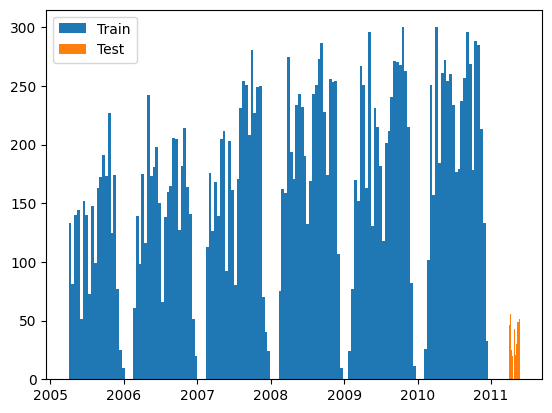

In [5]:
training_start = gc_train_df['Date'].min()
training_end = gc_train_df['Date'].max()
testing_start = gc_test_df['Date'].min()
testing_end = gc_test_df['Date'].max()
date_range_training = training_end - training_start
date_range_testing = testing_end - testing_start
print(f'training_start: {training_start}, training_end: {training_end}, date_range_training: {date_range_training}')
print(f'testing_start: {testing_start}, testing_end: {testing_end}, date_range_testing: {date_range_testing}')

fig, ax = plt.subplots()
ax.hist(gc_train_df['Date'], bins=150, label='Train')
ax.hist(gc_test_df['Date'],  bins=10, label='Test')
ax.legend()

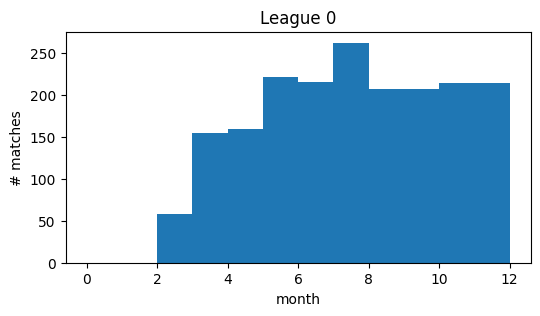

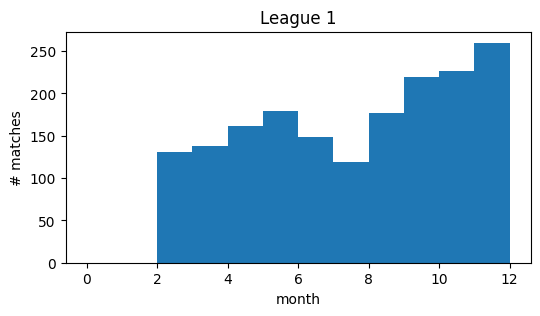

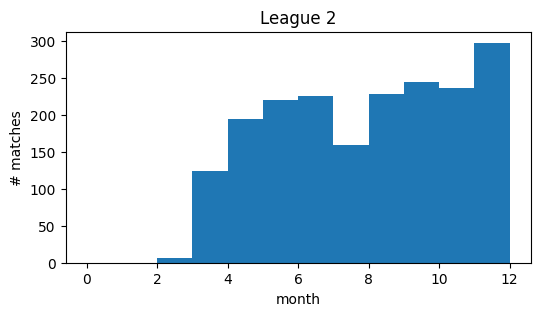

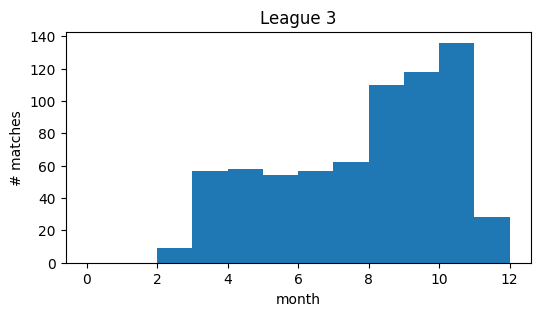

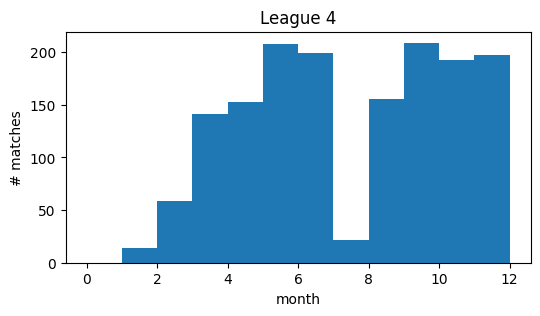

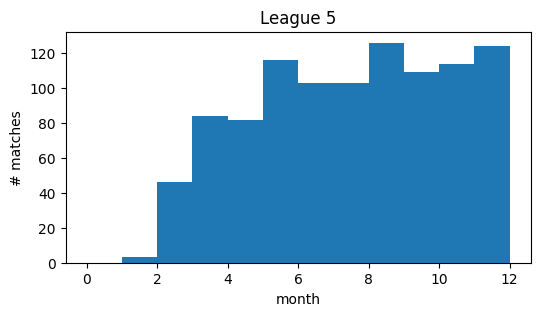

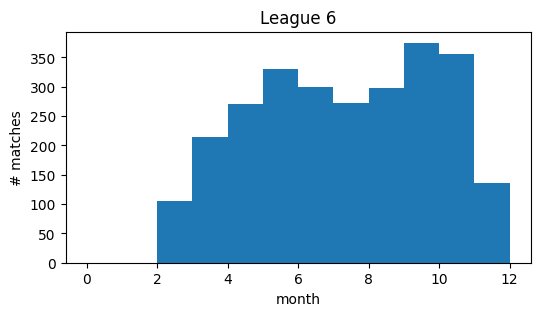

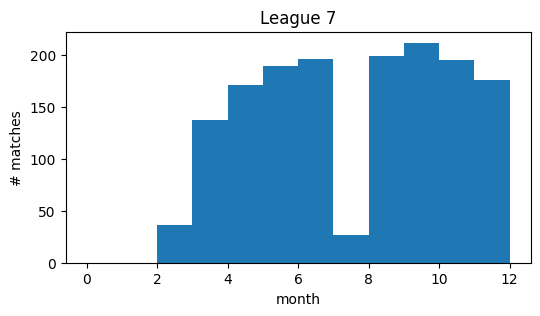

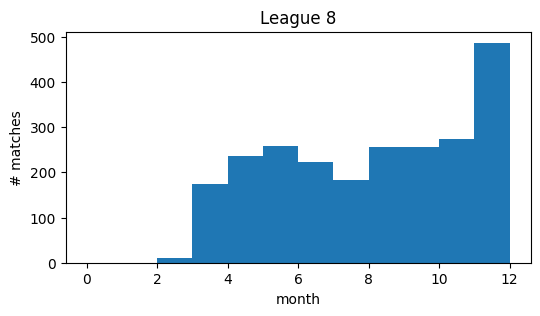

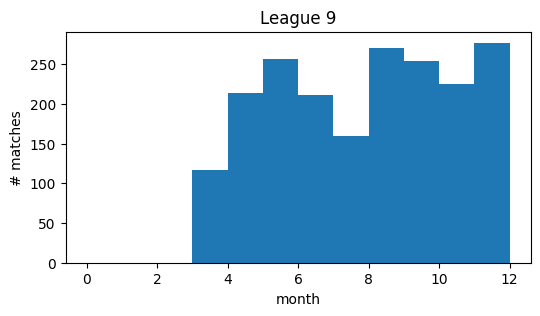

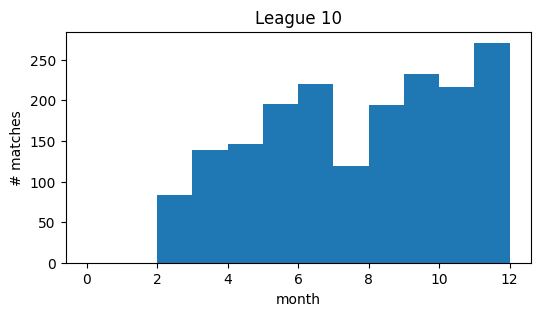

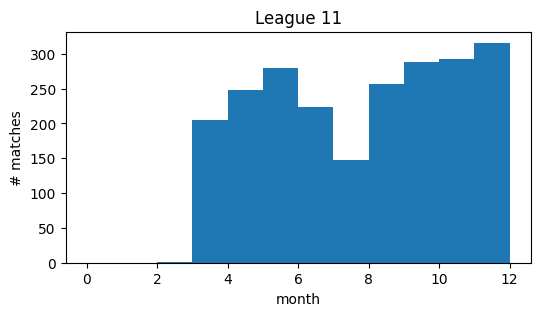

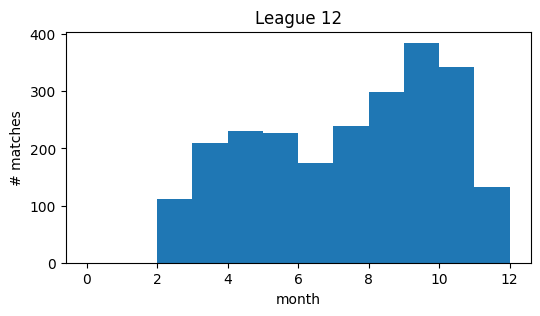

In [6]:
for league, data in gc_train_df.groupby('LeagueId'):
    fig,ax = plt.subplots(figsize=(6,3))
    ax.set_title(f'League {league}')
    ax.hist(data.month,bins=np.linspace(0,12,13))
    ax.set_ylabel('# matches')
    ax.set_xlabel('month')

In [7]:
for league, data in gc_train_df.groupby('LeagueId'):
    league_min = data['month'].min()
    league_max = data['month'].max()
    print(f'League {league} lasts from month {league_min}-{league_max} ')

League 0 lasts from month 2-12 
League 1 lasts from month 2-12 
League 2 lasts from month 2-12 
League 3 lasts from month 2-12 
League 4 lasts from month 1-12 
League 5 lasts from month 1-12 
League 6 lasts from month 2-12 
League 7 lasts from month 2-12 
League 8 lasts from month 2-12 
League 9 lasts from month 3-12 
League 10 lasts from month 2-12 
League 11 lasts from month 2-12 
League 12 lasts from month 2-11 


Data has structured annual seasons with most leagues not playing in January. Several leagues seem to have a reduced schedule in June/July.

## Feature extraction
We have historical data for the home/away goals and corners in the training dataset along with team and league Id's and dates. Can use training data to construct variables that can be used to predict the data in the test dataset. Check the overall differences between home and away teams in terms of the corners and goals they typically score (idea of home advantage).

Home Team Mean: 5.726, Away Team Mean: 4.493
Home Team std: 2.845, Away Team std: 2.505
T-test statistic: -50.198, pval: 0.0


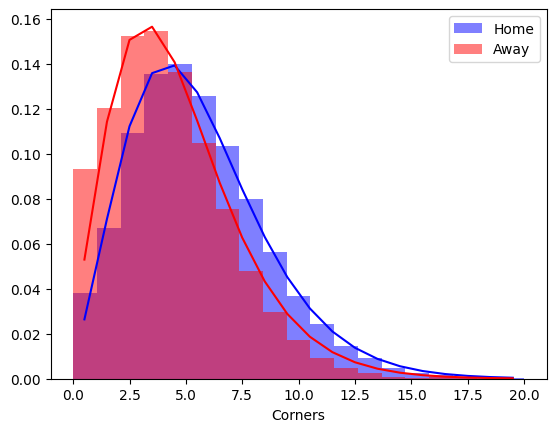

In [8]:
HCM , ACM = gc_train_df[['Home_Corners','Away_Corners']].mean()
print(f'Home Team Mean: {HCM:.3f}, Away Team Mean: {ACM:.3f}')
HCS , ACS = gc_train_df[['Home_Corners','Away_Corners']].std()
print(f'Home Team std: {HCS:.3f}, Away Team std: {ACS:.3f}')

t_stat, pval = scipy.stats.ttest_ind(gc_train_df['Away_Corners'], gc_train_df['Home_Corners'])
print(f'T-test statistic: {t_stat:.3f}, pval: {pval}')

h_nbinom = nbinom.pmf(range(20),HCM,0.53)
a_nbinom = nbinom.pmf(range(20),ACM,0.52)
poiss_points = [i - 0.5 for i in range(1, 20 + 1)]
fig, ax, = plt.subplots()
bins_ = np.linspace(0,20,20)
ax.hist(gc_train_df['Home_Corners'], bins=bins_, label='Home', alpha=0.5, density=True, color='blue')
ax.plot(poiss_points, h_nbinom, color='blue')
ax.plot(poiss_points, a_nbinom, color='red')
ax.hist(gc_train_df['Away_Corners'], bins=bins_, label='Away', alpha=0.5, density=True,color='red')
ax.set_xlabel('Corners')
ax.legend()

These distributions could follow a Poisson or negative binomial distribution with a probability of success/corner parameter just above 0.5. There is, on average, a home advantage when it comes to winning corners, which can be seen by the mean of the distribution. The T-test looks to reject the null hypothesis that states that the EV of the sample of corners won by the away team, is the same as the mean drawn from the Home team sample. The p-value of the resulting test statistic allows us to reject this hypothesis (also checked this holds for individual teams)

Check averages and trends observed in the training data: yearly/monthly/league/team averages for corners and goals.

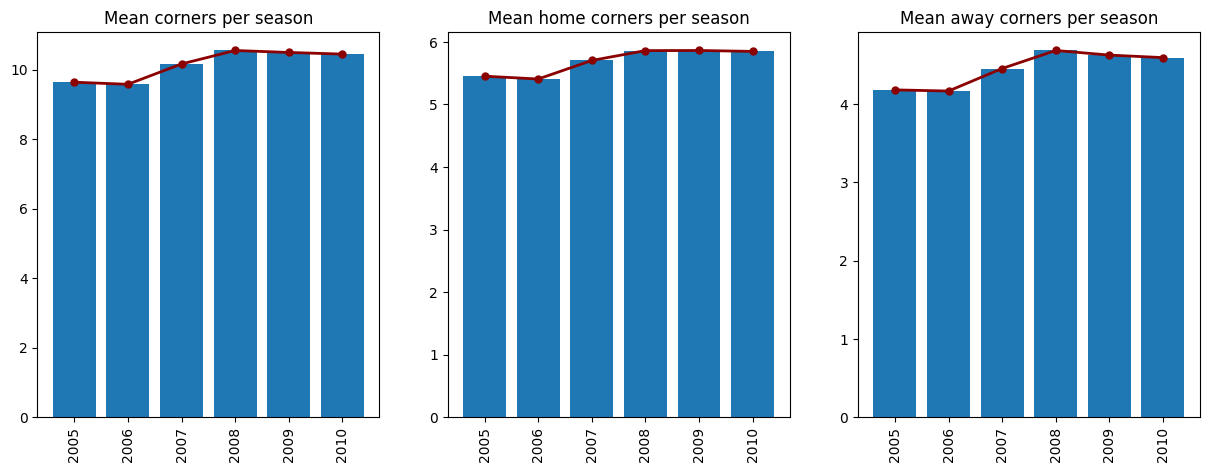

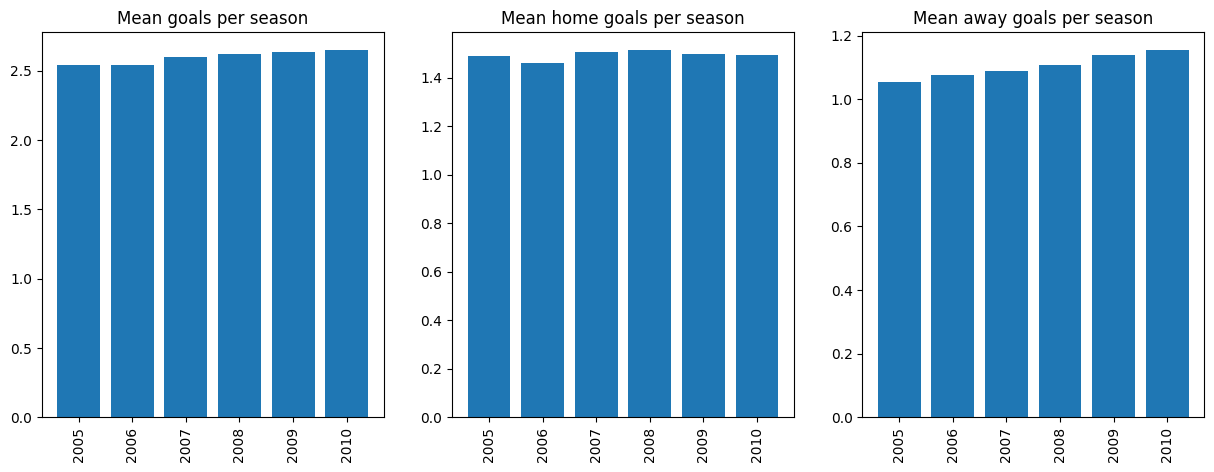

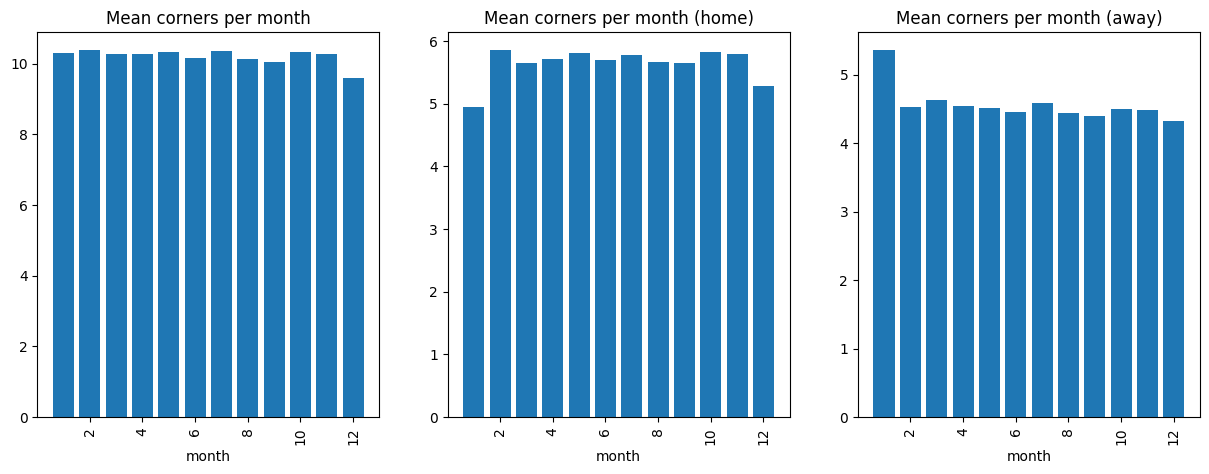

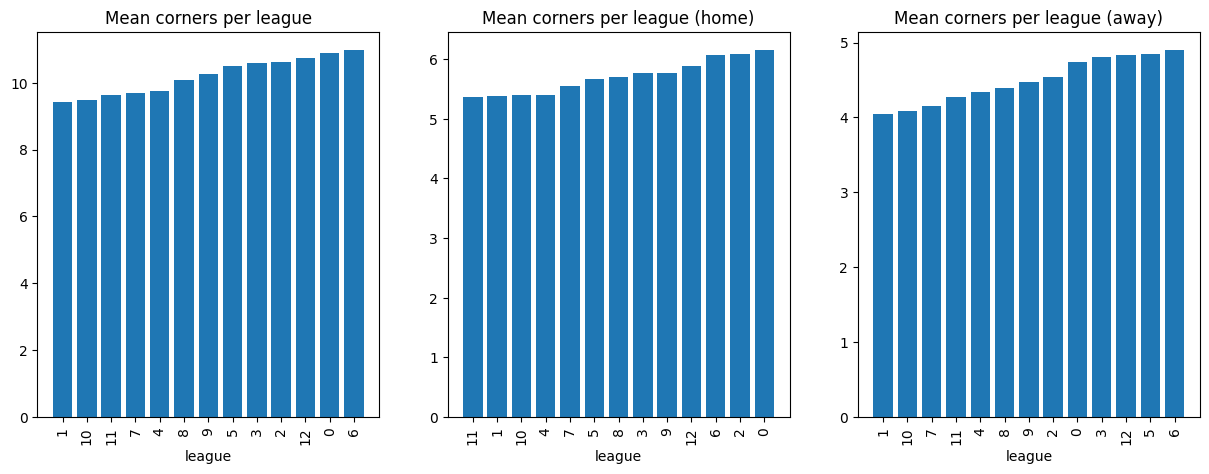

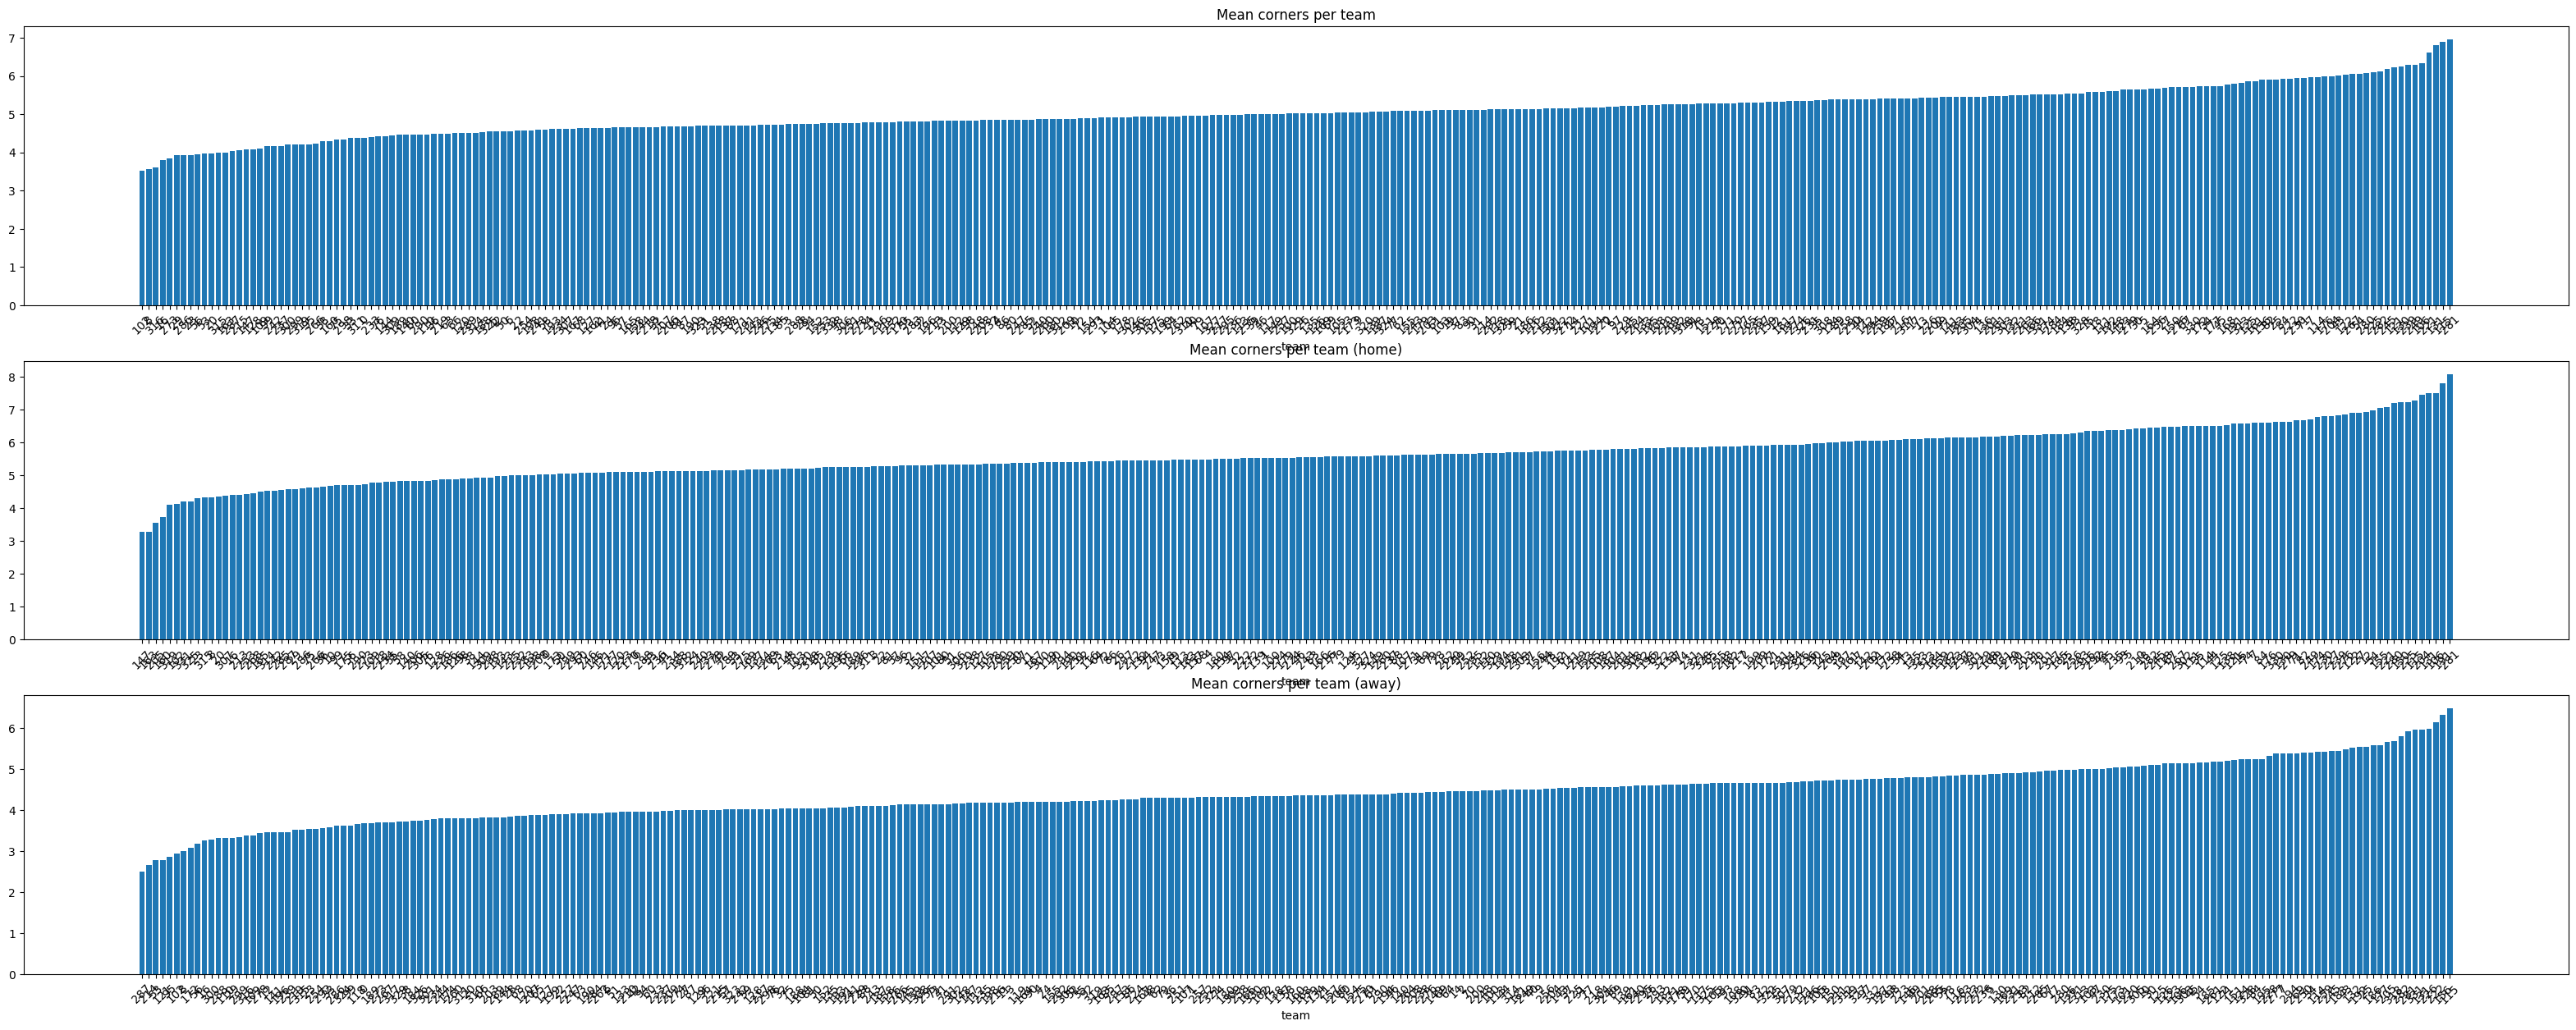

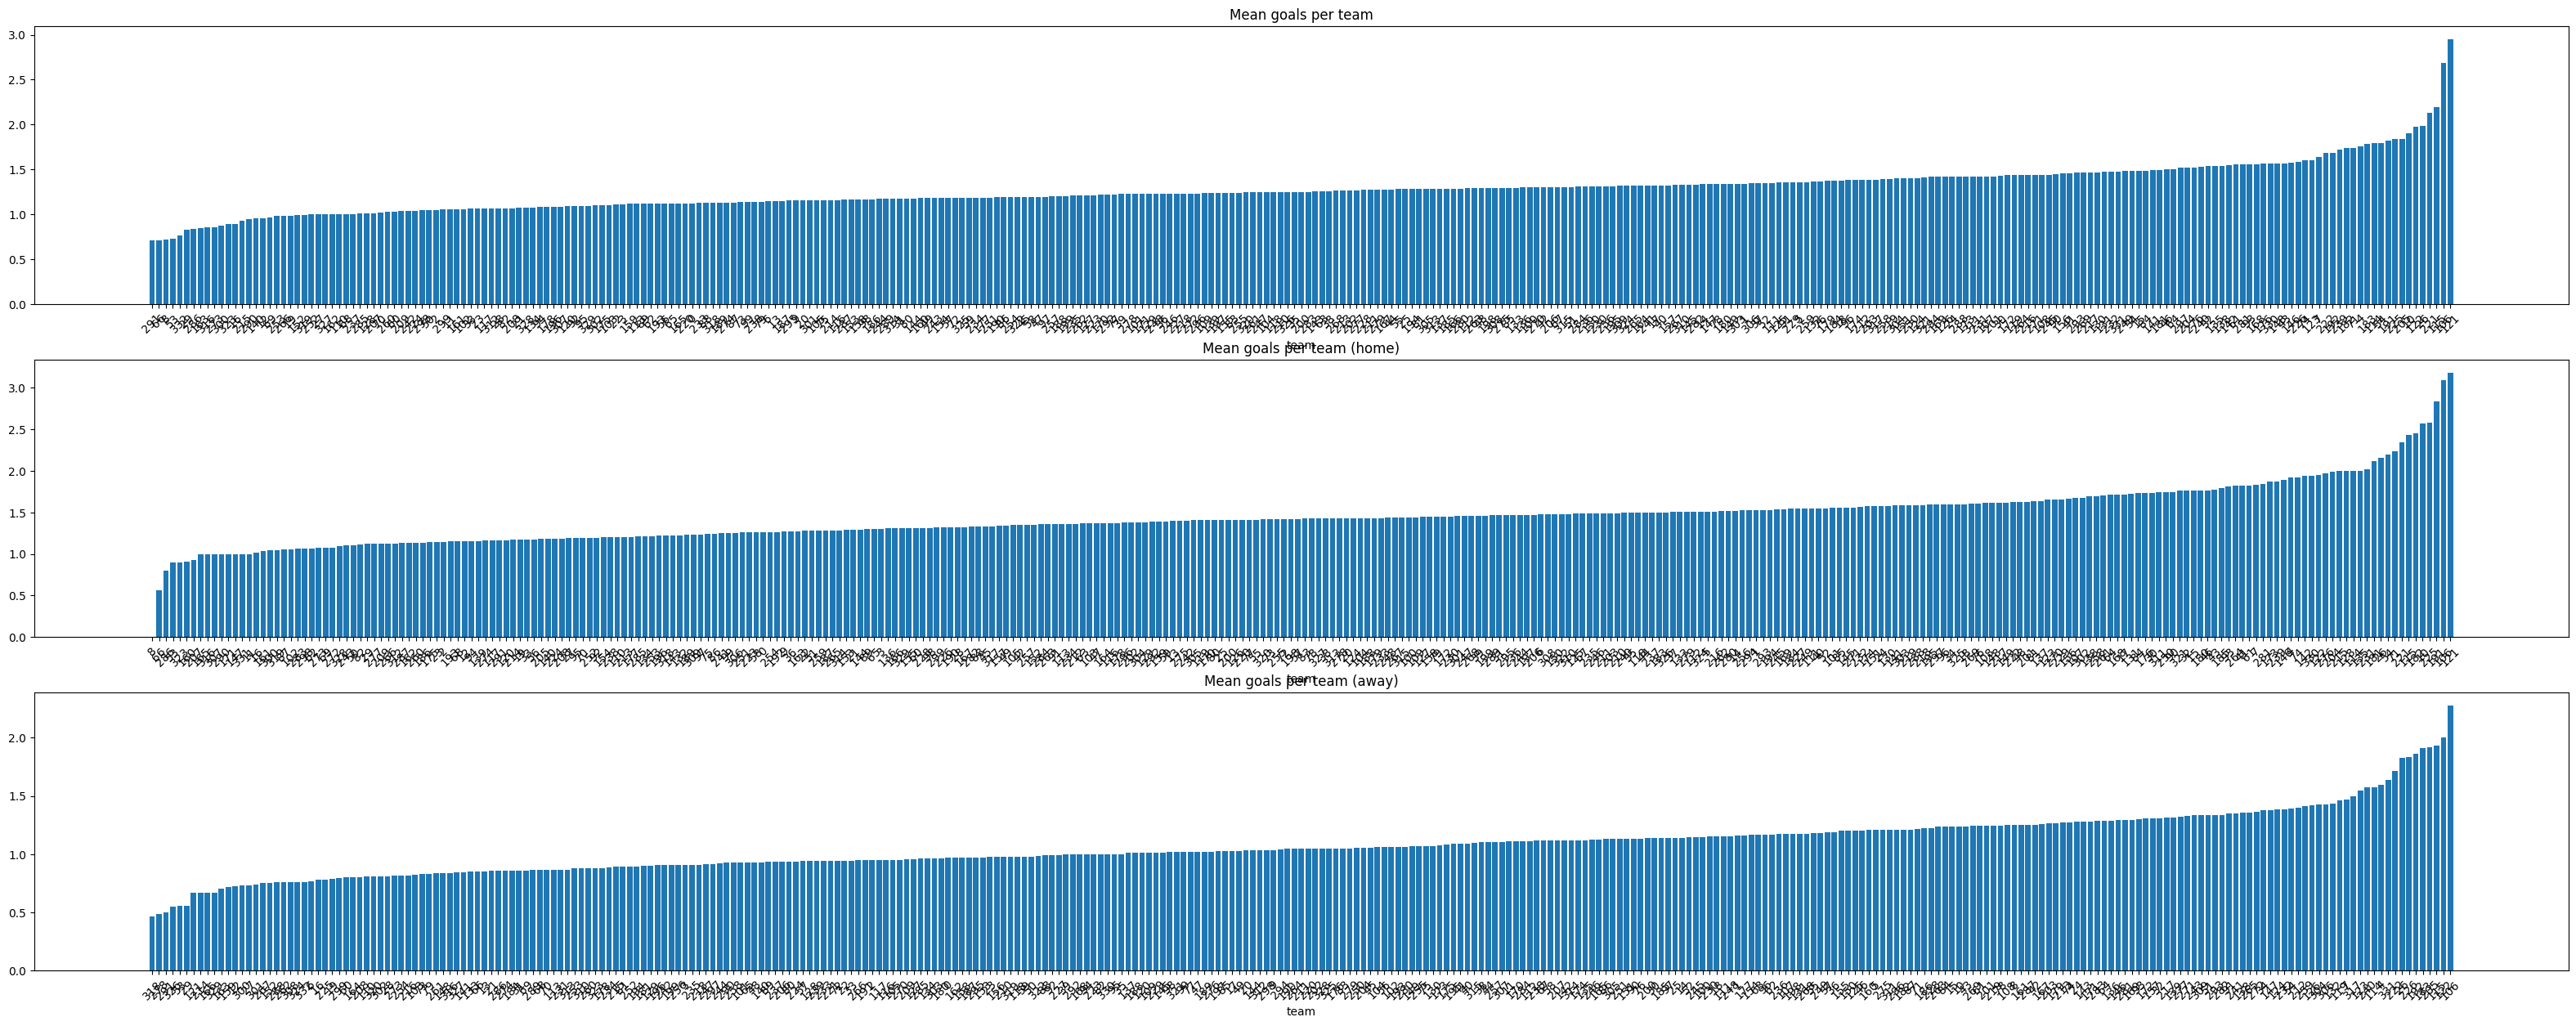

In [9]:
# Per season
fig,ax=plt.subplots(1,3,figsize=(15,5))
season_avg_corners = gc_train_df.groupby('year')[['Home_Corners','Away_Corners']].mean().sum(axis=1)
season_homeavg_corners = gc_train_df.groupby('year')['Home_Corners'].mean()
season_awayavg_corners = gc_train_df.groupby('year')['Away_Corners'].mean()
ax[0].plot(season_avg_corners.index, season_avg_corners.values, color='darkred', marker='o', linewidth=2, markersize=5)
ax[0].set_title('Mean corners per season')
ax[0].bar(season_avg_corners.index,season_avg_corners.values,label='Total')
ax[0].tick_params(axis='x',rotation=90)
ax[1].plot(season_homeavg_corners.index, season_homeavg_corners.values, color='darkred', marker='o',linewidth=2, markersize=5)
ax[1].set_title('Mean home corners per season')
ax[1].bar(season_homeavg_corners.index,season_homeavg_corners.values,label='Home')
ax[1].tick_params(axis='x',rotation=90)
ax[2].plot(season_awayavg_corners.index, season_awayavg_corners.values, color='darkred', marker='o',linewidth=2, markersize=5)
ax[2].set_title('Mean away corners per season')
ax[2].bar(season_awayavg_corners.index,season_awayavg_corners.values,label='Away')
ax[2].tick_params(axis='x',rotation=90)

fig,ax=plt.subplots(1,3,figsize=(15,5))
season_avg_goals = gc_train_df.groupby('year')[['Home_Goals','Away_Goals']].mean().sum(axis=1)
season_homeavg_goals = gc_train_df.groupby('year')['Home_Goals'].mean()
season_awayavg_goals = gc_train_df.groupby('year')['Away_Goals'].mean()
ax[0].set_title('Mean goals per season')
ax[0].bar(season_avg_goals.index,season_avg_goals.values,label='Total')
ax[0].tick_params(axis='x',rotation=90)
ax[1].set_title('Mean home goals per season')
ax[1].bar(season_homeavg_goals.index,season_homeavg_goals.values,label='Home')
ax[1].tick_params(axis='x',rotation=90)
ax[2].set_title('Mean away goals per season')
ax[2].bar(season_awayavg_goals.index,season_awayavg_goals.values,label='Away')
ax[2].tick_params(axis='x',rotation=90)

# Per month
fig,ax=plt.subplots(1,3,figsize=(15,5))
monthly_avg_corners = gc_train_df.groupby('month')[['Home_Corners','Away_Corners']].mean().sum(axis=1)
monthly_avg_home_corners = gc_train_df.groupby('month')['Home_Corners'].mean()
monthly_avg_away_corners = gc_train_df.groupby('month')['Away_Corners'].mean()
ax[0].set_title('Mean corners per month')
ax[0].bar(monthly_avg_corners.index,monthly_avg_corners.values,label='Total')
ax[0].set_xlabel('month')
ax[0].tick_params(axis='x',rotation=90)
ax[1].set_title('Mean corners per month (home)')
ax[1].bar(monthly_avg_home_corners.index,monthly_avg_home_corners.values,label='Total')
ax[1].set_xlabel('month')
ax[1].tick_params(axis='x',rotation=90)
ax[2].set_title('Mean corners per month (away)')
ax[2].bar(monthly_avg_away_corners.index,monthly_avg_away_corners.values,label='Total')
ax[2].set_xlabel('month')
ax[2].tick_params(axis='x',rotation=90)

# Per League
fig,ax=plt.subplots(1,3,figsize=(15,5))
league_avg_corners = gc_train_df.groupby('LeagueId')[['Home_Corners','Away_Corners']].mean().sum(axis=1)
league_avg_corners.sort_values(ascending=True, inplace=True)
league_homeavg_corners = gc_train_df.groupby('LeagueId')['Home_Corners'].mean()
league_homeavg_corners.sort_values(inplace=True)
league_awayavg_corners = gc_train_df.groupby('LeagueId')['Away_Corners'].mean()
league_awayavg_corners.sort_values(inplace=True)
ax[0].set_title('Mean corners per league')
ax[0].bar(league_avg_corners.index.astype('str'),league_avg_corners.values,label='Total')
ax[0].set_xlabel('league')
ax[0].tick_params(axis='x',rotation=90)
ax[1].set_title('Mean corners per league (home)')
ax[1].bar(league_homeavg_corners.index.astype('str'),league_homeavg_corners.values,label='Total')
ax[1].set_xlabel('league')
ax[1].tick_params(axis='x',rotation=90)
ax[2].set_title('Mean corners per league (away)')
ax[2].bar(league_awayavg_corners.index.astype('str'),league_awayavg_corners.values,label='Total')
ax[2].set_xlabel('league')
ax[2].tick_params(axis='x',rotation=90)

# Per Team
tmp_data_ = pd.concat([
    gc_train_df[['HomeTeamId','Home_Goals','Home_Corners']].assign(home=1).rename(columns={'HomeTeamId':'team', 'Home_Goals':'goals', 'Home_Corners':'corners'}),
    gc_train_df[['AwayTeamId','Away_Goals','Away_Corners']].assign(home=0).rename(columns={'AwayTeamId':'team', 'Away_Goals':'goals', 'Away_Corners':'corners'})
    ])
fig,ax=plt.subplots(3,1,figsize=(40,15))
team_homeavg_corners = gc_train_df.groupby('HomeTeamId')['Home_Corners'].mean()
team_awayavg_corners = gc_train_df.groupby('AwayTeamId')['Away_Corners'].mean()
team_avg_corners = tmp_data_.groupby('team')[['corners']].mean()
team_avg_corners.sort_values(by='corners',inplace=True)
team_homeavg_corners.sort_values(inplace=True)
team_awayavg_corners.sort_values(inplace=True)
ax[0].set_title('Mean corners per team')
ax[0].bar(team_avg_corners.index.astype('str'),team_avg_corners['corners'],label='Total')
ax[0].set_xlabel('team')
ax[0].tick_params(axis='x',rotation=45)
ax[1].set_title('Mean corners per team (home)')
ax[1].bar(team_homeavg_corners.index.astype('str'),team_homeavg_corners.values,label='Total')
ax[1].set_xlabel('team')
ax[1].tick_params(axis='x',rotation=45)
ax[2].set_title('Mean corners per team (away)')
ax[2].bar(team_awayavg_corners.index.astype('str'),team_awayavg_corners.values,label='Total')
ax[2].set_xlabel('team')
ax[2].tick_params(axis='x',rotation=45)

fig,ax=plt.subplots(3,1,figsize=(40,15))
team_homeavg_goals = gc_train_df.groupby('HomeTeamId')['Home_Goals'].mean()
team_awayavg_goals = gc_train_df.groupby('AwayTeamId')['Away_Goals'].mean()
team_avg_goals = tmp_data_.groupby('team')[['goals']].mean()
team_avg_goals.sort_values(by='goals',inplace=True)
team_homeavg_goals.sort_values(inplace=True)
team_awayavg_goals.sort_values(inplace=True)

ax[0].set_title('Mean goals per team')
ax[0].bar(team_avg_goals.index.astype('str'),team_avg_goals['goals'],label='Total')
ax[0].set_xlabel('team')
ax[0].tick_params(axis='x',rotation=45)
ax[1].set_title('Mean goals per team (home)')
ax[1].bar(team_homeavg_goals.index.astype('str'),team_homeavg_goals.values,label='Total')
ax[1].set_xlabel('team')
ax[1].tick_params(axis='x',rotation=45)
ax[2].set_title('Mean goals per team (away)')
ax[2].bar(team_awayavg_goals.index.astype('str'),team_awayavg_goals.values,label='Total')
ax[2].set_xlabel('team')
ax[2].tick_params(axis='x',rotation=45)

We can test whether the number of goals/corners for different groupings e.g. teams, leagues, months etc. is significant or not using ANOVA

In [28]:
# Create list of corners for Home team IDs
home_corners_match_list = gc_train_df.groupby('HomeTeamId')['Home_Corners'].apply(list).to_dict()
away_corners_match_list = gc_train_df.groupby('AwayTeamId')['Away_Corners'].apply(list).to_dict()
# Convert dictionary to list of lists for ANOVA
home_anova_list = list(home_corners_match_list.values())
home_anova_result = scipy.stats.f_oneway(*home_anova_list)
away_anova_list = list(away_corners_match_list.values())
away_anova_result = scipy.stats.f_oneway(*away_anova_list)
print(f'ANOVA')
print(f'Home: statistic={home_anova_result.statistic:.5f}, p-value={home_anova_result.pvalue}')
print(f'Away: statistic={away_anova_result.statistic:.5f}, p-value={away_anova_result.pvalue}')

ANOVA
Home: statistic=4.01905, p-value=2.777444243477538e-115
Away: statistic=3.83398, p-value=3.6610511308877093e-106


The small p-value suggests there's a statistically significant difference in the number of corners taken by different teams whether home or away.

{0: [7, 8, 8, 10, 8, 9, 14, 8, 14, 14, 9, 6, 12, 14, 9, 10, 13, 5, 16, 12, 11, 10, 2, 8, 9, 12, 10, 13, 10, 7, 10, 11, 14, 10, 8, 9, 13, 6, 12, 4, 9, 12, 10, 16, 11, 10, 16, 9, 10, 8, 9, 7, 6, 10, 16, 10, 8, 8, 5, 15, 14, 11, 10, 8, 18, 14, 7, 12, 14, 10, 13, 7, 15, 13, 9, 8, 7, 6, 13, 13, 11, 12, 13, 7, 11, 15, 9, 17, 11, 11, 10, 11, 8, 10, 7, 19, 9, 4, 9, 11, 13, 20, 11, 15, 11, 6, 10, 8, 8, 13, 15, 8, 14, 9, 11, 10, 9, 11, 9, 9, 10, 21, 8, 8, 14, 6, 7, 16, 12, 12, 7, 9, 15, 13, 11, 9, 8, 14, 2, 11, 12, 14, 15, 11, 9, 10, 5, 8, 7, 7, 11, 10, 15, 8, 7, 6, 11, 10, 11, 8, 11, 4, 15, 9, 7, 7, 13, 14, 2, 6, 9, 7, 8, 7, 5, 9, 10, 14, 15, 11, 10, 9, 15, 17, 17, 9, 9, 6, 16, 12, 8, 9, 7, 11, 13, 11, 12, 7, 13, 9, 9, 19, 15, 5, 13, 7, 13, 19, 6, 19, 12, 7, 7, 11, 11, 12, 5, 18, 10, 9, 16, 15, 9, 9, 8, 8, 8, 13, 9, 7, 8, 8, 11, 7, 7, 13, 11, 7, 9, 11, 14, 12, 10, 8, 10, 13, 7, 14, 14, 6, 4, 8, 7, 9, 5, 9, 7, 7, 7, 8, 10, 12, 11, 10, 10, 8, 9, 12, 7, 10, 3, 11, 12, 13, 18, 11, 16, 12, 8, 5, 6, 

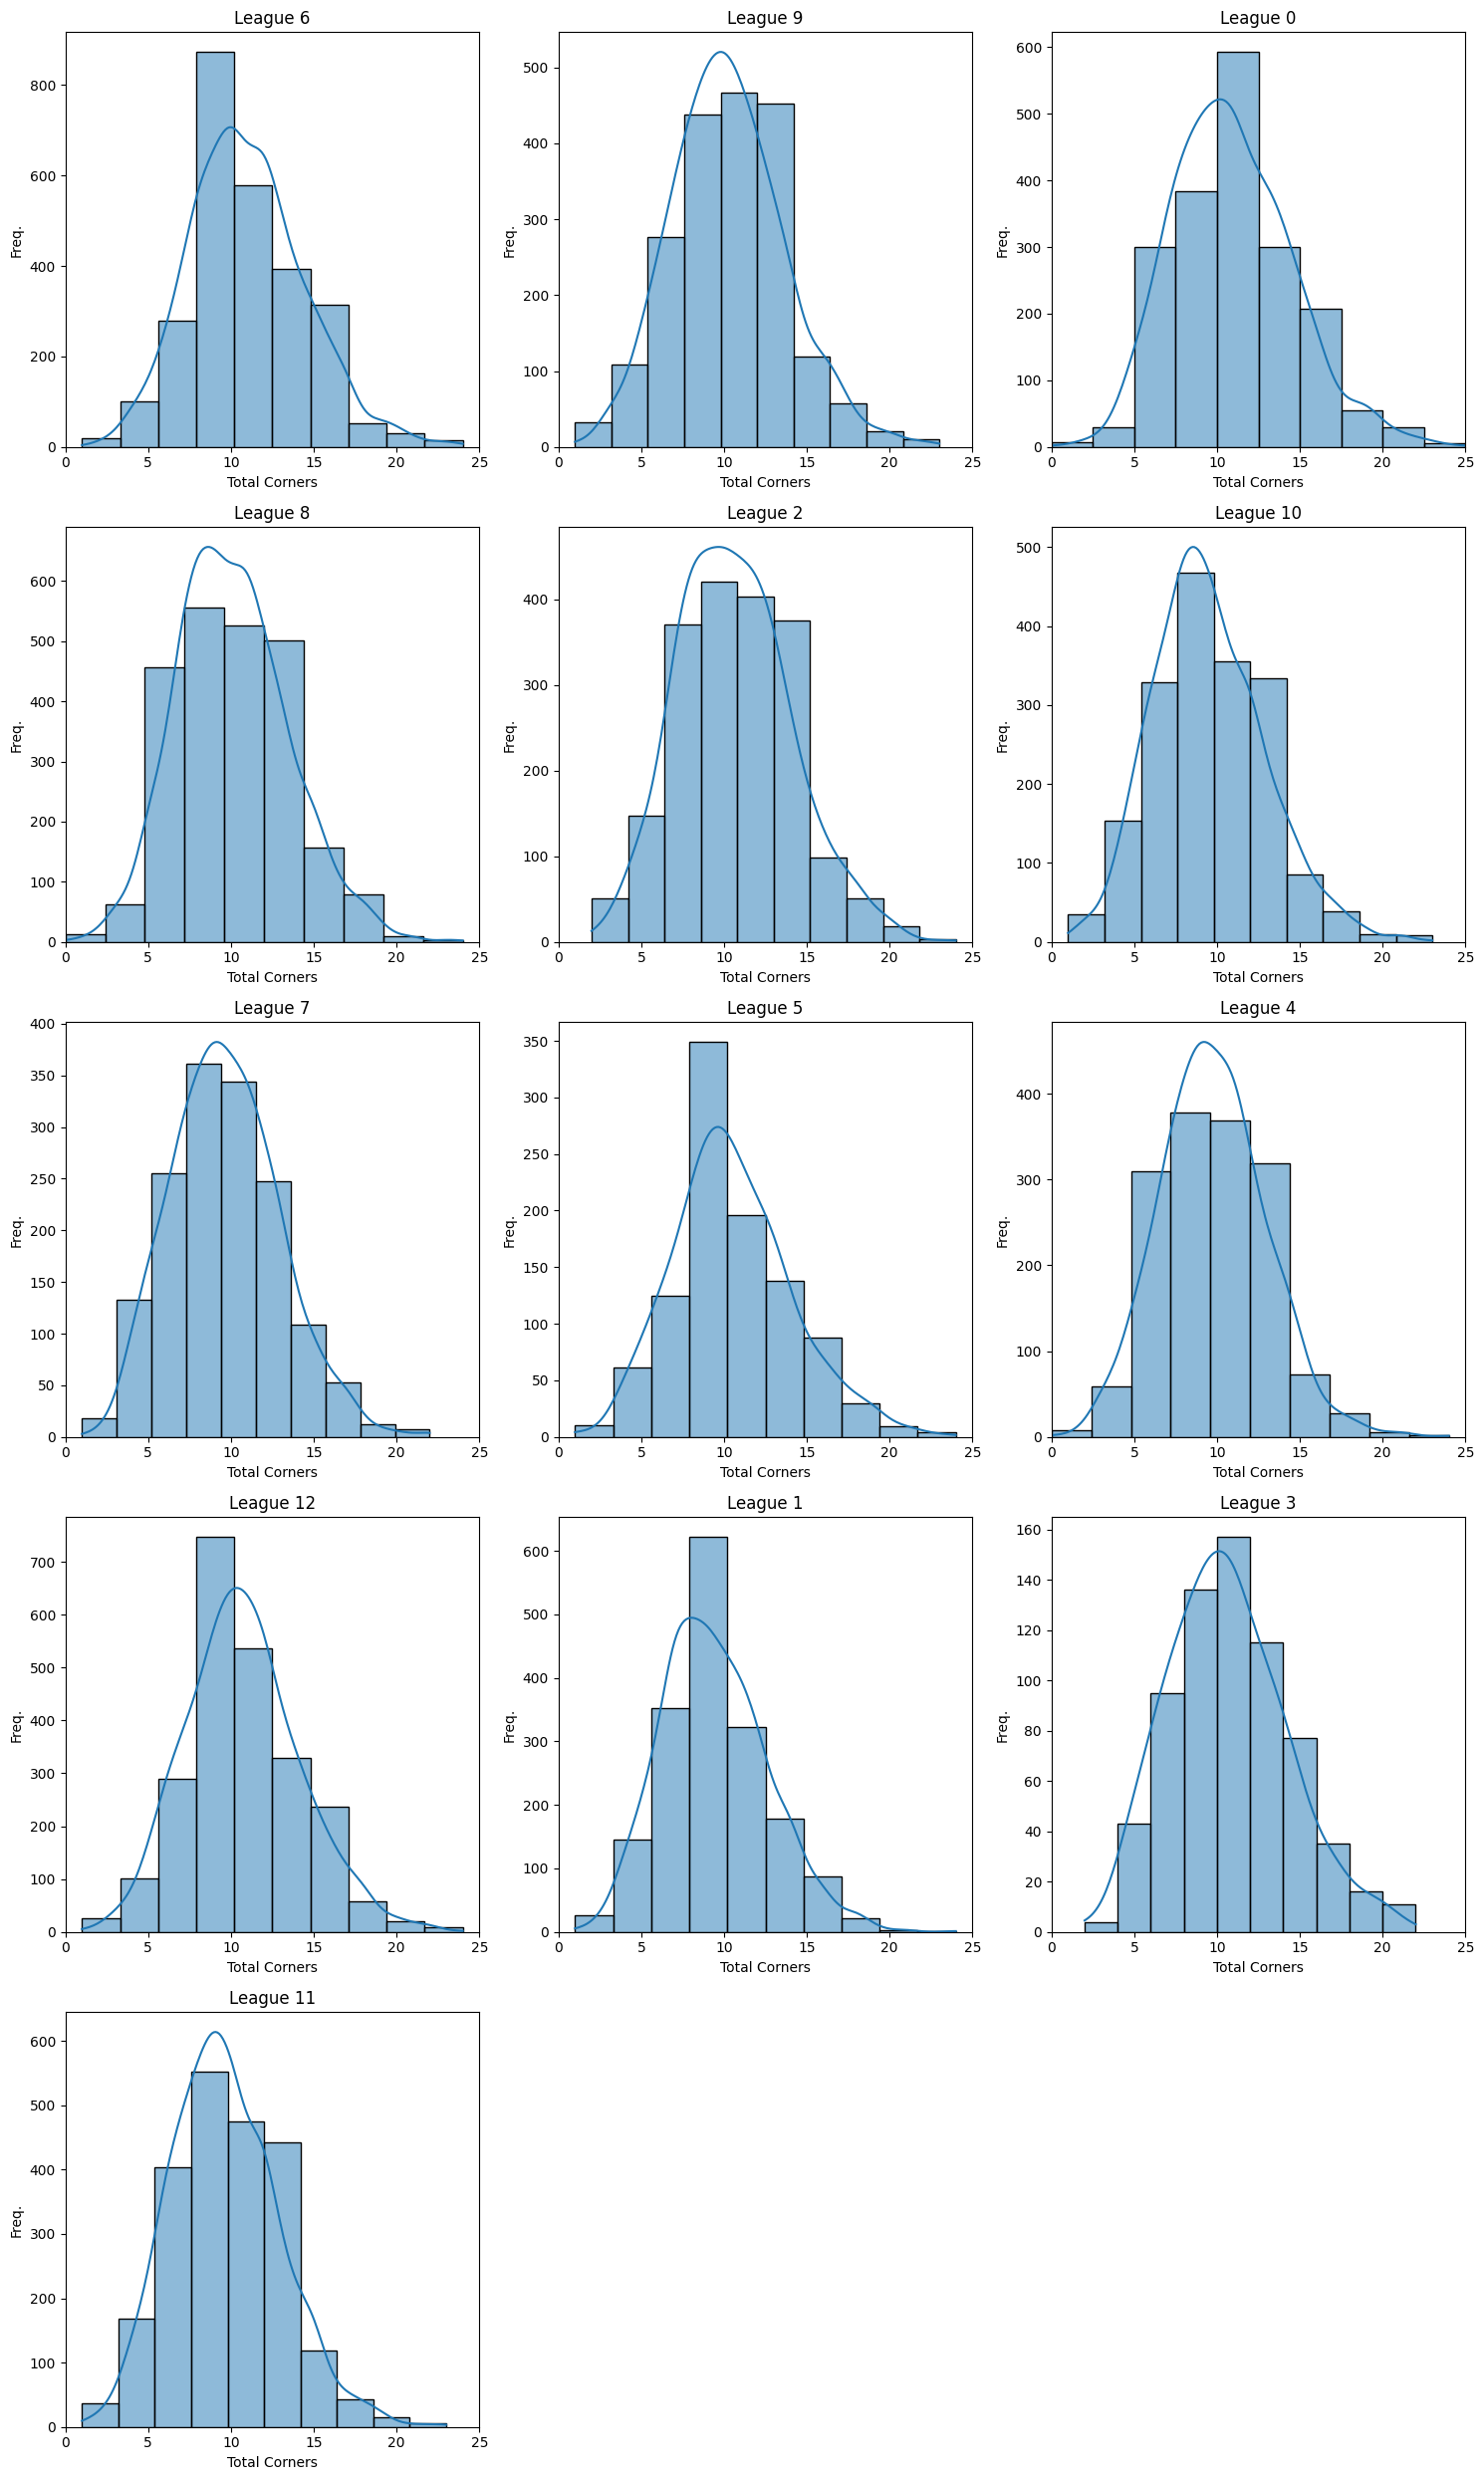

In [49]:
# Create list of corners for League IDs
gc_train_df['Total_Corners'] = gc_train_df['Home_Corners'] + gc_train_df['Away_Corners']
corners_league_list = gc_train_df.groupby('LeagueId')['Total_Corners'].apply(list).to_dict()
# Convert dictionary to list of lists for ANOVA
league_anova_list = list(corners_league_list.values())
league_anova_result = scipy.stats.f_oneway(*league_anova_list)
print(f'ANOVA')
print(f'League: statistic={league_anova_result.statistic:.5f}, p-value={league_anova_result.pvalue}')
leagues = gc_train_df['LeagueId'].unique()
cols=3
import math
rows=math.ceil(len(leagues)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
# flatten axes array in case of single row
axes = axes.flatten()
# Min/max axis
x_min = gc_train_df['Total_Corners'].min()
x_max = gc_train_df['Total_Corners'].max()
for i, league in enumerate(leagues):
    sns.histplot(gc_train_df[gc_train_df['LeagueId']==league]['Total_Corners'],bins=10,kde=True,ax=axes[i])
    axes[i].set_title(f'League {league}')
    axes[i].set_xlabel("Total Corners")
    axes[i].set_ylabel("Freq.")
    axes[i].set_xlim(x_min,x_max)
# Tidy up!
# if there are additional remaining subplots but no leagues to fill them, we can remove the axes
for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])
# ensure x-axis label is vis
plt.subplots_adjust(hspace=5., wspace=0.3)

plt.tight_layout()
plt.show()

{1: [9, 12, 8, 14, 11, 10, 7, 14, 6, 10, 9, 10, 6, 11, 8, 11, 19], 2: [12, 10, 9, 3, 12, 8, 8, 4, 14, 16, 22, 14, 12, 10, 10, 15, 13, 10, 9, 16, 14, 8, 7, 6, 12, 6, 11, 10, 10, 15, 9, 12, 10, 7, 4, 6, 5, 12, 6, 10, 9, 13, 12, 8, 11, 8, 7, 5, 9, 10, 14, 15, 11, 8, 13, 14, 8, 10, 9, 15, 13, 9, 9, 7, 11, 10, 7, 4, 9, 12, 10, 15, 7, 12, 8, 11, 6, 8, 14, 7, 9, 11, 18, 7, 17, 5, 10, 12, 13, 13, 11, 15, 6, 17, 10, 8, 5, 10, 10, 11, 14, 8, 8, 13, 10, 11, 15, 17, 18, 11, 7, 13, 9, 7, 13, 13, 12, 8, 4, 8, 8, 9, 12, 12, 9, 13, 9, 19, 10, 5, 10, 4, 12, 6, 10, 9, 2, 8, 15, 8, 16, 10, 9, 10, 12, 8, 6, 10, 4, 7, 9, 14, 12, 5, 11, 3, 14, 8, 14, 8, 10, 8, 10, 11, 14, 9, 14, 7, 11, 9, 11, 8, 9, 6, 10, 10, 16, 12, 9, 14, 13, 10, 11, 12, 5, 17, 15, 5, 10, 12, 7, 15, 14, 11, 8, 11, 2, 8, 8, 11, 7, 9, 12, 16, 12, 7, 13, 8, 7, 11, 5, 9, 9, 13, 13, 6, 5, 10, 13, 9, 13, 13, 6, 5, 18, 10, 9, 11, 15, 7, 8, 9, 9, 14, 18, 14, 13, 15, 6, 11, 16, 9, 10, 8, 9, 10, 7, 12, 12, 10, 20, 14, 12, 11, 8, 15, 10, 7, 8, 13, 9

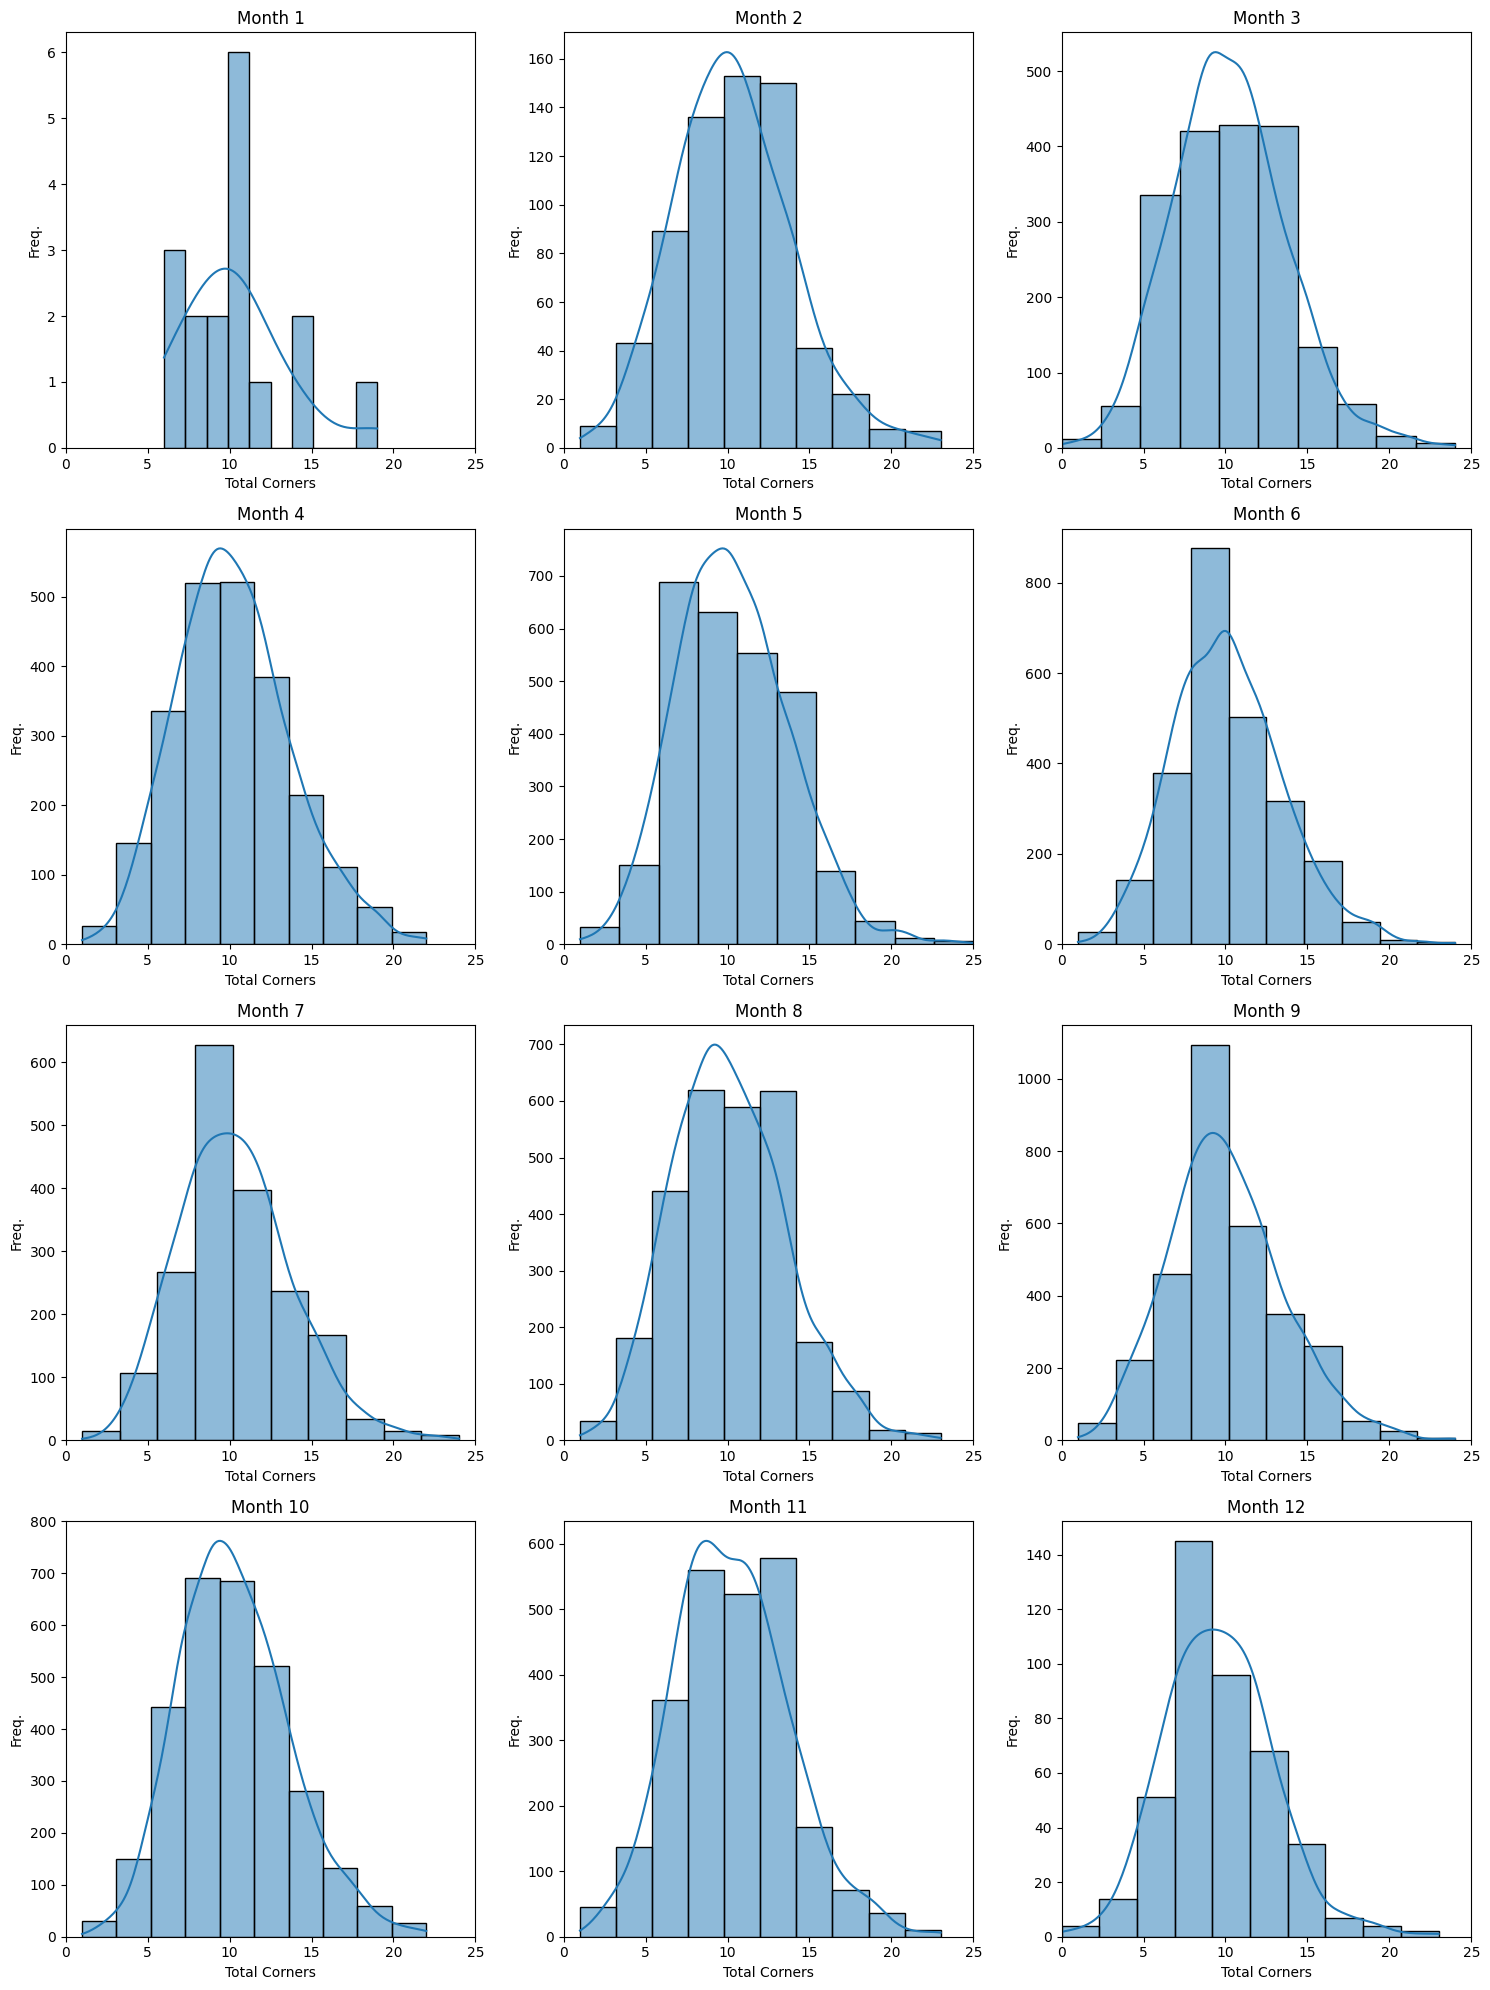

In [58]:
# Create list of corners for League IDs
corners_month_list = gc_train_df.groupby('month')['Total_Corners'].apply(list).to_dict()
print(corners_month_list)
# Convert dictionary to list of lists for ANOVA
month_anova_list = list(corners_month_list.values())
month_anova_result = scipy.stats.f_oneway(*month_anova_list)
print(f'ANOVA')
print(f'Monthly: statistic={month_anova_result.statistic:.5f}, p-value={month_anova_result.pvalue}')

months = gc_train_df['month'].unique()
months = np.sort(months)
cols=3
rows=math.ceil(len(months)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
# flatten axes array in case of single row
axes = axes.flatten()
# min max axes
x_min = gc_train_df['Total_Corners'].min()
x_max = gc_train_df['Total_Corners'].max()
for i, month in enumerate(months):
    sns.histplot(gc_train_df[gc_train_df['month']==month]['Total_Corners'],bins=10,kde=True,ax=axes[i])
    axes[i].set_title(f'Month {month}')
    axes[i].set_xlabel("Total Corners")
    axes[i].set_ylabel("Freq.")
    axes[i].set_xlim(x_min,x_max)

# Tidy up!
# if there are additional remaining subplots but no leagues to fill them, we can remove the axes
for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])
# ensure x-axis label is vis
plt.subplots_adjust(hspace=5., wspace=0.3)

plt.tight_layout()
plt.show()

We can draw a similar conclusion for the total number of corners taken per match in the different leagues and months of the year, though the evidence rejecting the null hypothesis for the team and leagues is much stronger than for the months.

array([[1.        , 0.48884396],
       [0.48884396, 1.        ]])

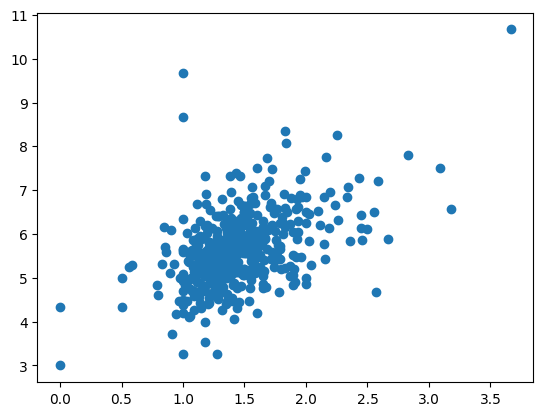

In [30]:
league_home_df = gc_train_df.groupby(['LeagueId','HomeTeamId']).agg(League_Goals_mean=('Home_Goals',np.mean), League_Corners_mean=('Home_Corners',np.mean))
league_away_df = gc_train_df.groupby(['LeagueId','AwayTeamId']).agg(League_Goals_mean=('Away_Goals',np.mean), League_Corners_mean=('Away_Corners',np.mean))
fig, ax = plt.subplots()
ax.scatter(league_home_df.League_Goals_mean, league_home_df.League_Corners_mean)
np.corrcoef(league_home_df.League_Goals_mean, league_home_df.League_Corners_mean)

Text(0, 0.5, 'Team Mean Corners')

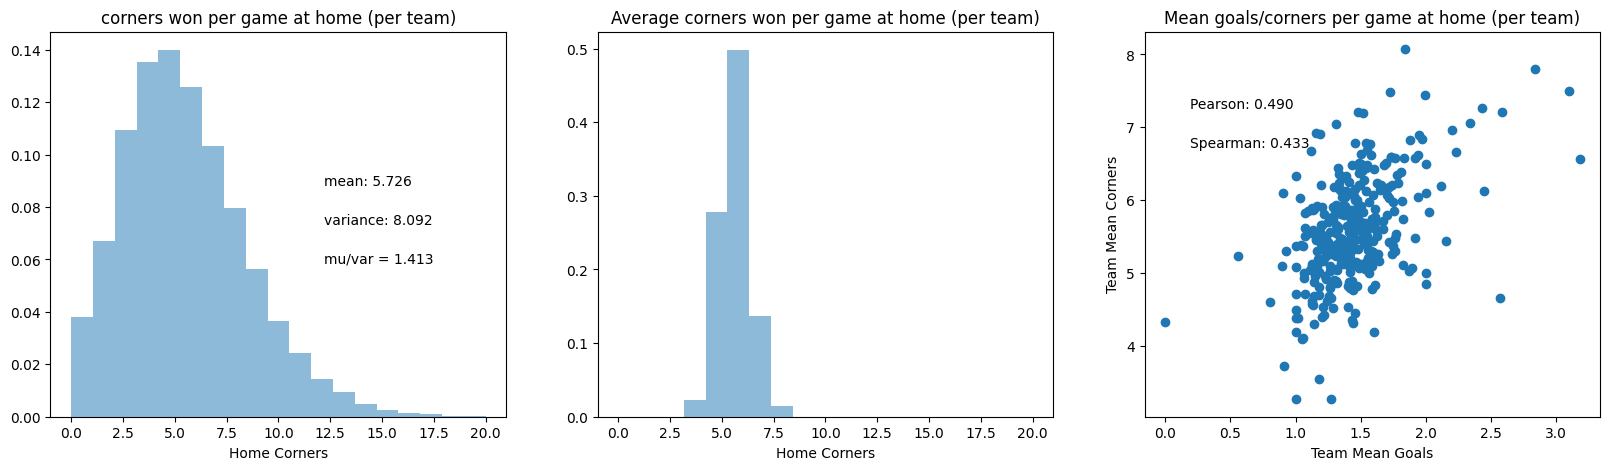

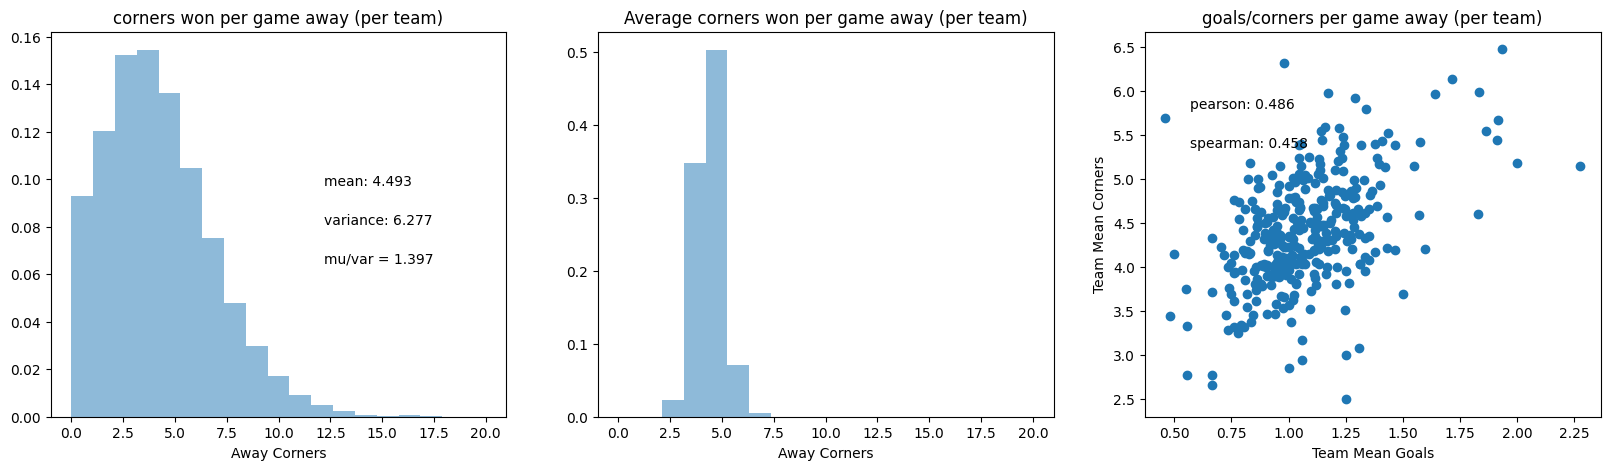

In [25]:
# Home team
home_df = gc_train_df.groupby(['HomeTeamId']).agg(Home_Goals_mean=('Home_Goals',np.mean), Home_Corners_mean=('Home_Corners',np.mean))
# Away team
away_df = gc_train_df.groupby(['AwayTeamId']).agg(Away_Goals_mean=('Away_Goals',np.mean), Away_Corners_mean=('Away_Corners',np.mean))

# Sample statistics
mean_home_corners = gc_train_df['Home_Corners'].mean()
var_home_corners = gc_train_df['Home_Corners'].std()**2

fig, ax = plt.subplots(1,3,figsize=(20,5))
# 1D distributions
bins_ = np.linspace(0,20,20)
ax[0].set_title('corners won per game at home (per team)')
stat_mean = f'mean: {mean_home_corners:.3f}'
stat_var = f'variance: {var_home_corners:.3f}'
var_to_mean = f'mu/var = {var_home_corners/mean_home_corners:.3f}'
ax[0].text(0.6, 0.6, stat_mean , transform = ax[0].transAxes)
ax[0].text(0.6, 0.5, stat_var , transform = ax[0].transAxes)
ax[0].text(0.6, 0.4, var_to_mean , transform = ax[0].transAxes)
ax[0].hist(gc_train_df['Home_Corners'], bins=bins_, label='Corners', alpha=0.5, density=True)
ax[0].set_xlabel('Home Corners')
ax[1].set_title('Average corners won per game at home (per team)')
ax[1].hist(home_df['Home_Corners_mean'], bins=bins_, label='Average per team', alpha=0.5, density=True)
ax[1].set_xlabel('Home Corners')

# Correlation
ax[2].set_title('Mean goals/corners per game at home (per team)')
#home_corr = home_df['Home_Goals_mean'].corr(home_df['Home_Corners_mean'])
pearson = scipy.stats.pearsonr(home_df['Home_Goals_mean'].values,home_df['Home_Corners_mean'].values)
spearman = scipy.stats.spearmanr(home_df['Home_Goals_mean'].values,home_df['Home_Corners_mean'].values)
ax[2].scatter(home_df['Home_Goals_mean'], home_df['Home_Corners_mean'])
ax[2].text(0.1, 0.8, f'Pearson: {pearson[0]:.3f}', transform = ax[2].transAxes)
ax[2].text(0.1, 0.7, f'Spearman: {spearman[0]:.3f}', transform = ax[2].transAxes)
ax[2].set_xlabel('Team Mean Goals')
ax[2].set_ylabel('Team Mean Corners')

# sample statistics
mean_away_corners = gc_train_df['Away_Corners'].mean()
var_away_corners = gc_train_df['Away_Corners'].std()**2

fig, ax = plt.subplots(1,3,figsize=(20,5))
bins_ = np.linspace(0,20,20)
ax[0].set_title('corners won per game away (per team)')
stat_mean = f'mean: {mean_away_corners:.3f}'
stat_var = f'variance: {var_away_corners:.3f}'
var_to_mean = f'mu/var = {var_away_corners/mean_away_corners:.3f}'
ax[0].text(0.6, 0.6, stat_mean , transform = ax[0].transAxes)
ax[0].text(0.6, 0.5, stat_var , transform = ax[0].transAxes)
ax[0].text(0.6, 0.4, var_to_mean , transform = ax[0].transAxes)
ax[0].hist(gc_train_df['Away_Corners'], bins=bins_, label='Corners', alpha=0.5, density=True)
ax[0].set_xlabel('Away Corners')

ax[1].set_title('Average corners won per game away (per team)')
ax[1].hist(away_df['Away_Corners_mean'], bins=bins_, label='Average per team', alpha=0.5, density=True)
ax[1].set_xlabel('Away Corners')

ax[2].set_title('goals/corners per game away (per team)')
#away_corr = away_df['Away_Goals_mean'].corr(away_df['Away_Corners_mean'])
pearson = scipy.stats.pearsonr(away_df['Away_Goals_mean'].values,away_df['Away_Corners_mean'].values)
spearman = scipy.stats.spearmanr(away_df['Away_Goals_mean'].values,away_df['Away_Corners_mean'].values)
ax[2].text(0.1, 0.8, f'pearson: {pearson[0]:.3f}', transform = ax[2].transAxes)
ax[2].text(0.1, 0.7, f'spearman: {spearman[0]:.3f}', transform = ax[2].transAxes)
ax[2].scatter(away_df['Away_Goals_mean'], away_df['Away_Corners_mean'])
ax[2].set_xlabel('Team Mean Goals')
ax[2].set_ylabel('Team Mean Corners')

From the 1D distributions we notice that the variance-to-mean ratio is approximately 1.4 which indicates overdispersion. This could be because corners often result in subsequent corners leading to clusters and violating the distribution assumption of a Poisson random variable i.e. corners are independent events. This is consistent with the Negative Binomial distribution. 

There is a Pearson correlation of approximately 0.5 between the mean corners and goals per game suggesting a moderate to strong linear correlation. 
This indicates that a model aiming to estimate the mean parameter of a distribution of the total number of corners in a game for two teams, might benefit from the knowing the number of goals the team is likely to score.

## Feature engineering
We can split the training dataset into a train and test set to backtest the model first. Based on the EDA, it seems the following features constructed from historical training data would make useful predictors of the number of corners in a match given the teams and league information:<br>
    - (Rolling) average goals/corners per team at home/away/total<br>
    - (Rolling) average goals/corners per league at home/away/total<br>
    - Relative strength statistics of the two teams playing (expected number of goals/corners/goal diff.)<br>

For the test data set, impute values of features from the previous season(s) to predict the values for the games in the test dataset. If there are NaN values for a new team in the test data, its average is set to the league average.

In [12]:
def create_training_data(original_dataset, start_date = None, end_date=None):
    if start_date == None:
        start_date = original_dataset['year'].min()
    if end_date == None:
        end_date = original_dataset['year'].max()

    # Training and feature extraction uses training dataset only
    X_train = original_dataset[(original_dataset['year']>=start_date) & (original_dataset['year']<=end_date)]
    Y_train = original_dataset[(original_dataset['year']>=start_date) & (original_dataset['year']<=end_date)]['Home_Corners']
        
    X_train['Match_Total_Corners'] = X_train['Home_Corners'] + X_train['Away_Corners']
    X_train['Match_Total_Goals'] = X_train['Home_Goals'] + X_train['Away_Goals']

    # Annual avg per team
    agg_home_df = X_train.groupby(['HomeTeamId','year']).agg(
        home_goals_av=('Home_Goals','mean'),
        home_corners_av=('Home_Corners','mean'),
        ).reset_index()
    agg_away_df = X_train.groupby(['AwayTeamId','year']).agg(
        away_goals_av=('Away_Goals','mean'),
        away_corners_av=('Away_Corners','mean'),
        ).reset_index()
    X_train = X_train.merge(agg_home_df, on=['HomeTeamId','year'], how='left')
    X_train = X_train.merge(agg_away_df, on=['AwayTeamId','year'], how='left')

    # League avg per team
    agg_home_df = X_train.groupby(['HomeTeamId','LeagueId']).agg(
        league_home_goals_av=('Home_Goals','mean'),
        league_home_corners_av=('Home_Corners','mean'),
        ).reset_index()
    agg_away_df = X_train.groupby(['AwayTeamId','LeagueId']).agg(
        league_away_goals_av=('Away_Goals','mean'),
        league_away_corners_av=('Away_Corners','mean'),
        ).reset_index()
    # overall
    agg_league_df = X_train.groupby('LeagueId')['Match_Total_Corners'].mean().rename('Mean_Corners_Per_League')

    X_train = X_train.merge(agg_home_df, on=['HomeTeamId','LeagueId'], how='left')
    X_train = X_train.merge(agg_away_df, on=['AwayTeamId','LeagueId'], how='left')
    X_train = X_train.merge(agg_league_df, on=['LeagueId'], how='left')

    # Recent form per team
    X_train['Home_corners_3form'] = X_train.groupby('HomeTeamId')['Home_Corners'].shift(1).transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    X_train['Away_corners_3form'] = X_train.groupby('AwayTeamId')['Away_Corners'].shift(1).transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    X_train['Home_corners_10form'] = X_train.groupby('HomeTeamId')['Home_Corners'].shift(1).transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    X_train['Away_corners_10form'] = X_train.groupby('AwayTeamId')['Away_Corners'].shift(1).transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    X_train['Home_goals_3form'] = X_train.groupby('HomeTeamId')['Home_Goals'].shift(1).transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    X_train['Away_goals_3form'] = X_train.groupby('AwayTeamId')['Away_Goals'].shift(1).transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    X_train['Home_goals_10form'] = X_train.groupby('HomeTeamId')['Home_Goals'].shift(1).transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    X_train['Away_goals_10form'] = X_train.groupby('AwayTeamId')['Away_Goals'].shift(1).transform(lambda x: x.rolling(window=10, min_periods=1).mean())

    X_train['Home_corners_10form'].fillna(X_train['league_home_corners_av'], inplace=True)
    X_train['Away_corners_10form'].fillna(X_train['league_away_corners_av'], inplace=True)
    X_train['Home_corners_3form'].fillna(X_train['league_home_corners_av'], inplace=True)
    X_train['Away_corners_3form'].fillna(X_train['league_away_corners_av'], inplace=True)
    X_train['Home_goals_3form'].fillna(X_train['league_home_goals_av'], inplace=True)
    X_train['Away_goals_3form'].fillna(X_train['league_away_goals_av'], inplace=True)
    X_train['Home_goals_10form'].fillna(X_train['league_home_goals_av'], inplace=True)
    X_train['Away_goals_10form'].fillna(X_train['league_away_goals_av'], inplace=True)

    # Team averages (to date)
    # Home
    X_train['cum_home_goals'] = X_train.groupby(['HomeTeamId','year'])['Home_Goals'].cumsum()
    X_train['cum_home_corners'] = X_train.groupby(['HomeTeamId','year'])['Home_Corners'].cumsum()
    X_train['year_home_games_played'] = X_train.groupby(['HomeTeamId','year']).cumcount()+1
    X_train['goals_per_home_game'] = X_train['cum_home_goals']/X_train['year_home_games_played']
    X_train['corners_per_home_game'] = X_train['cum_home_corners']/X_train['year_home_games_played']
    # Away
    X_train['cum_away_goals'] = X_train.groupby(['AwayTeamId','year'])['Away_Goals'].cumsum()
    X_train['cum_away_corners'] = X_train.groupby(['AwayTeamId','year'])['Away_Corners'].cumsum()
    X_train['year_away_games_played'] = X_train.groupby(['AwayTeamId','year']).cumcount()+1
    X_train['goals_per_away_game'] = X_train['cum_away_goals']/X_train['year_away_games_played']
    X_train['corners_per_away_game'] = X_train['cum_away_corners']/X_train['year_away_games_played']

    # Supremecy
    X_train['total_corners_exp'] = X_train['Home_corners_3form'] + X_train['Away_corners_3form']
    X_train['rel_corner_sup'] = X_train['Home_corners_3form'] - X_train['Away_corners_3form']
    X_train['total_corners_exp'].fillna(X_train['league_home_corners_av']+X_train['league_away_corners_av'], inplace=True)
    X_train['rel_corner_sup'].fillna(X_train['league_home_corners_av']-X_train['league_away_corners_av'], inplace=True)

    X_train['total_goals_exp'] = X_train['Home_goals_3form'] + X_train['Away_corners_3form']
    X_train['rel_goals_sup'] = X_train['Home_goals_3form'] - X_train['Away_corners_3form']
    X_train['total_goals_exp'].fillna(X_train['league_home_goals_av']+X_train['league_away_goals_av'], inplace=True)
    X_train['rel_goals_sup'].fillna(X_train['league_home_goals_av']-X_train['league_away_goals_av'], inplace=True)
    return X_train, Y_train

X_train, Y_train = create_training_data(gc_train_df, 2005, 2009)

## Test data imputation
We now impute the test data with values from the historical training data. Entries are matched on the Home/Away team Id, League ID and year. The test data is assigned the last year in the data set so that for any annual averages, it is assigned statistics calculated using the previous season. Rolling averages are imputed with the latest rolling average recorded. Missing values associated with new teams arriving in the test data are dealt with by assigning them the league average values as we have no other data on them and this seems like a reasonable approximation (though this would come with higher risk).

In [13]:
def create_testing_data(original_dataset, X_train, start_date=None, target_present=0):
    
    original_dataset['year'] = original_dataset['Date'].dt.year

    if start_date == None:
        start_date = original_dataset['year'].min()

    # Hold out test data from average calculation and training
    X_test = original_dataset[(original_dataset['year']>=start_date)]

    if target_present==1:
        X_test['Match_Total_Corners'] = X_test['Home_Corners'] + X_test['Away_Corners']
        X_test['Match_Total_Goals'] = X_test['Home_Goals'] + X_test['Away_Goals']

    # Filter averaged features to get those from last season
    latest_year = X_train['year'].max()
    latest_data = X_train[X_train['year']==latest_year]
    X_test['year'] = latest_year
    agg_home_df = latest_data.groupby(['HomeTeamId','year']).agg(
        home_goals_av=('Home_Goals','mean'),
        home_corners_av=('Home_Corners','mean'),
        ).reset_index()
    agg_away_df = latest_data.groupby(['AwayTeamId','year']).agg(
        away_goals_av=('Away_Goals','mean'),
        away_corners_av=('Away_Corners','mean'),
        ).reset_index()

    # Avg per league
    # per team
    agg_home_league_df = X_train.groupby(['HomeTeamId','LeagueId']).agg(
        league_home_goals_av=('Home_Goals','mean'),
        league_home_corners_av=('Home_Corners','mean'),
        ).reset_index()
    agg_away_league_df = X_train.groupby(['AwayTeamId','LeagueId']).agg(
        league_away_goals_av=('Away_Goals','mean'),
        league_away_corners_av=('Away_Corners','mean'),
        ).reset_index()
    # overall
    agg_league_df = X_train.groupby(['LeagueId']).agg(
        overall_league_home_goals_av=('Home_Goals','mean'),
        overall_league_home_corners_av=('Home_Corners','mean'),
        overall_league_away_goals_av=('Away_Goals','mean'),
        overall_league_away_corners_av=('Away_Corners','mean'),
    ).reset_index()

    league_df = X_train.groupby('LeagueId')['Match_Total_Corners'].mean().rename('Mean_Corners_Per_League').reset_index()

    # Last form entries
    def add_last_entry(X_test, col):
        home_col = 'Home_'+ col
        away_col = 'Away_'+ col
        last_home = X_train.groupby('HomeTeamId').last().reset_index()[['HomeTeamId', home_col]]
        last_away = X_train.groupby('AwayTeamId').last().reset_index()[['AwayTeamId', away_col]]
        X_test = X_test.merge(last_home, on='HomeTeamId', how='left')
        X_test = X_test.merge(last_away, on='AwayTeamId', how='left')
        X_test[home_col].fillna(X_test[home_col].mean(), inplace=True)
        X_test[away_col].fillna(X_test[away_col].mean(), inplace=True)
        return X_test

    X_test = add_last_entry(X_test, 'corners_3form')
    X_test = add_last_entry(X_test, 'corners_10form')
    X_test = add_last_entry(X_test, 'goals_3form')
    X_test = add_last_entry(X_test, 'goals_10form')

    # Use the previous season as an estimate for the beginning of the test season
    X_test = X_test.merge(agg_home_df,on=['HomeTeamId','year'],how='left')
    X_test = X_test.merge(agg_away_df,on=['AwayTeamId','year'],how='left')
    X_test = X_test.merge(agg_league_df,on='LeagueId',how='left')
    X_test = X_test.merge(league_df,on='LeagueId',how='left')
    X_test = X_test.merge(agg_home_league_df,on=['HomeTeamId','LeagueId'],how='left')
    X_test = X_test.merge(agg_away_league_df,on=['AwayTeamId','LeagueId'],how='left')

    # NaN values
    # Where team ID has no match in training
    X_test['home_goals_av'].fillna(X_test['overall_league_home_goals_av'],inplace=True)
    X_test['away_goals_av'].fillna(X_test['overall_league_away_goals_av'],inplace=True)
    X_test['home_corners_av'].fillna(X_test['overall_league_home_corners_av'],inplace=True)
    X_test['away_corners_av'].fillna(X_test['overall_league_away_corners_av'],inplace=True)
    X_test['league_home_corners_av'].fillna(X_test['overall_league_home_corners_av'], inplace=True)
    X_test['league_away_corners_av'].fillna(X_test['overall_league_away_corners_av'], inplace=True)
    X_test['league_home_goals_av'].fillna(X_test['overall_league_home_goals_av'], inplace=True)
    X_test['league_away_goals_av'].fillna(X_test['overall_league_away_goals_av'], inplace=True)

    # Rolling averages
    X_test['Home_corners_10form'].fillna(X_test['overall_league_home_goals_av'], inplace=True)
    X_test['Away_corners_10form'].fillna(X_test['overall_league_away_goals_av'], inplace=True)
    X_test['Home_corners_3form'].fillna(X_test['overall_league_home_goals_av'], inplace=True)
    X_test['Away_corners_3form'].fillna(X_test['overall_league_away_goals_av'], inplace=True)
    X_test['Home_goals_3form'].fillna(X_test['overall_league_home_goals_av'], inplace=True)
    X_test['Away_goals_3form'].fillna(X_test['overall_league_away_goals_av'], inplace=True)
    X_test['Home_goals_10form'].fillna(X_test['overall_league_home_goals_av'], inplace=True)
    X_test['Away_goals_10form'].fillna(X_test['overall_league_away_goals_av'], inplace=True)

    # Supremecy
    X_test['total_corners_exp'] = X_test['Home_corners_3form'] + X_test['Away_corners_3form']
    X_test['rel_corner_sup'] = X_test['Home_corners_3form']-X_test['Away_corners_3form']
    X_test['total_goals_exp'] = X_test['Home_goals_3form']+X_test['Away_goals_3form']
    X_test['rel_goals_sup'] = X_test['Home_goals_3form']-X_test['Away_goals_3form']
    X_test['total_goals_exp'].fillna(X_test['league_home_goals_av']+X_test['league_away_goals_av'], inplace=True)
    X_test['rel_goals_sup'].fillna(X_test['overall_league_home_goals_av']-X_test['overall_league_away_goals_av'], inplace=True)
    return X_test

X_test = create_testing_data(gc_train_df, X_train, 2010, target_present=1)

Y_test = X_test['Match_Total_Corners']

## Models
Trying to model a discrete probability distribution describing the probability for a given number of corners occuring in a match. Such characteristics sound like they could be described by a Poisson distribution.

The Poisson distribution assumes that events are independent from one another and the occurence of one corner does not affect the probability of another. It also only has one free parameter, the mean, which also defines the variance. As we know from football matches, corners as they can often occur in flurries, with one corner making the probability of a second much higher than it would be from open play. This positive correlation could cause larger variances than if the events were independent due to a positive covariance term which may lead to overdispersion if we were to use a Poisson model. In which case, the Negative Binomial model provides an alternative for which the two parameters, the mean and dispersion, can be used to fit the data allowing the model to capture the larger variance.

2 models are therefore tested: a Poisson model and a Negative Binomial model. The output of both models provides an estimate of the mean parameter of the distribution. The Negative Binomial model also estimates the dispersion parameter from the data. Distributions of the number of total corners in the matches are constructed by sampling a random variable from the estimated distribution using the mean (and dispersion) predicted by the model. 

The correlation between potential independent variables are checked beneath.

<Axes: >

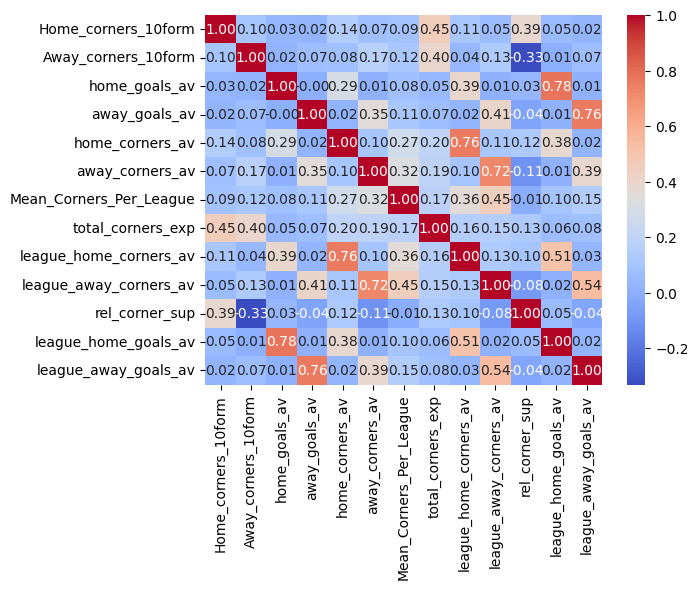

In [14]:
features_ = ['Home_corners_10form', 'Away_corners_10form',
             'home_goals_av','away_goals_av','home_corners_av','away_corners_av',
             'Mean_Corners_Per_League',
             'total_corners_exp',
             'league_home_corners_av', 'league_away_corners_av', 
             'rel_corner_sup',
             'league_home_goals_av', 'league_away_goals_av',
             ]

fig, ax = plt.subplots()
correlation_matrix = X_train[features_].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")


To improve the interpretibility of the models and improve the convergence of the fit procedure, I try to avoid using variables with extremely high correlation (>90%) simultaneously, as they can create non-unique solutions leading to unstable fit results and reduce the interpretability of the model as the effects of each indpendent variable become hard to disentangle. 

To further verify whether two variables with non-negligible correlation will be problematic in the fit, we can check the stability of the estimated coefficients for these parameters. If the coefficients of the suspects have large standard errors, it might indicate the features are redundant and the model might not be able to distinguish their individual effects. Furthermore, if the standard error is a simmlar size or larger than the coefficient itself, it the t-statistic of the coefficient might not be significant i.e. compatible with zero.

We could also asses this according to the Variance Inflation Factor i.e. how much the variance of a regression coefficient is inflated due to multicolinearity (1/1-R_squared) where the R_squared is the value obtained by regressing that predictor on others.

Input features are transformed using a log transformation as it was noted that several of the input features have a positive skewed distribution.

Optimization terminated successfully.
         Current function value: 2.616448
         Iterations: 17
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 2.619328
         Iterations 13
                      NegativeBinomial Regression Results                      
Dep. Variable:     Match_Total_Corners   No. Observations:                18984
Model:                NegativeBinomial   Df Residuals:                    18980
Method:                            MLE   Df Model:                            3
Date:                 Fri, 29 Nov 2024   Pseudo R-squ.:                0.008231
Time:                         11:22:15   Log-Likelihood:                -49671.
converged:                        True   LL-Null:                       -50083.
Covariance Type:             nonrobust   LLR p-value:                2.094e-178
                             coef    std err          z      P>|z|      [0.025      0

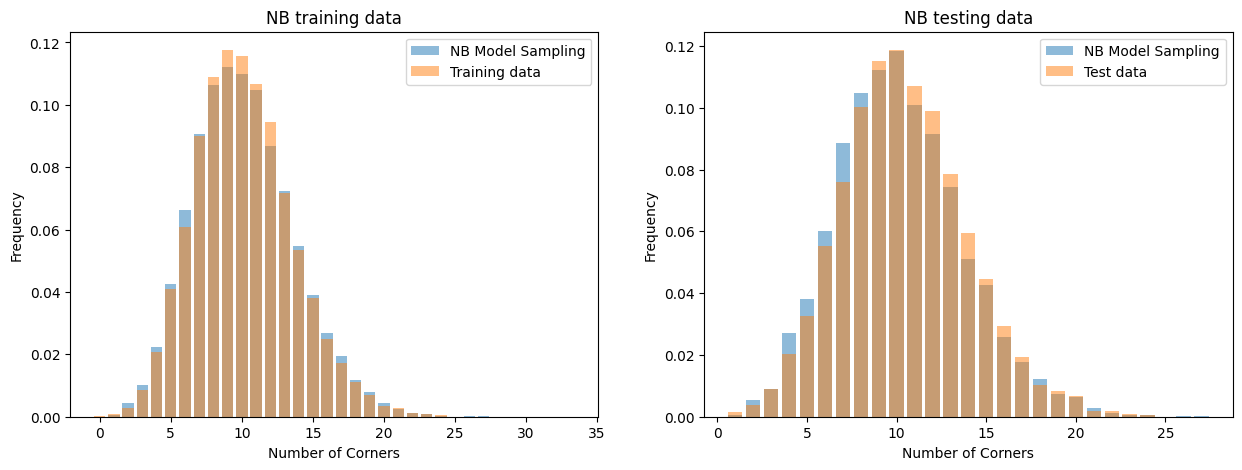

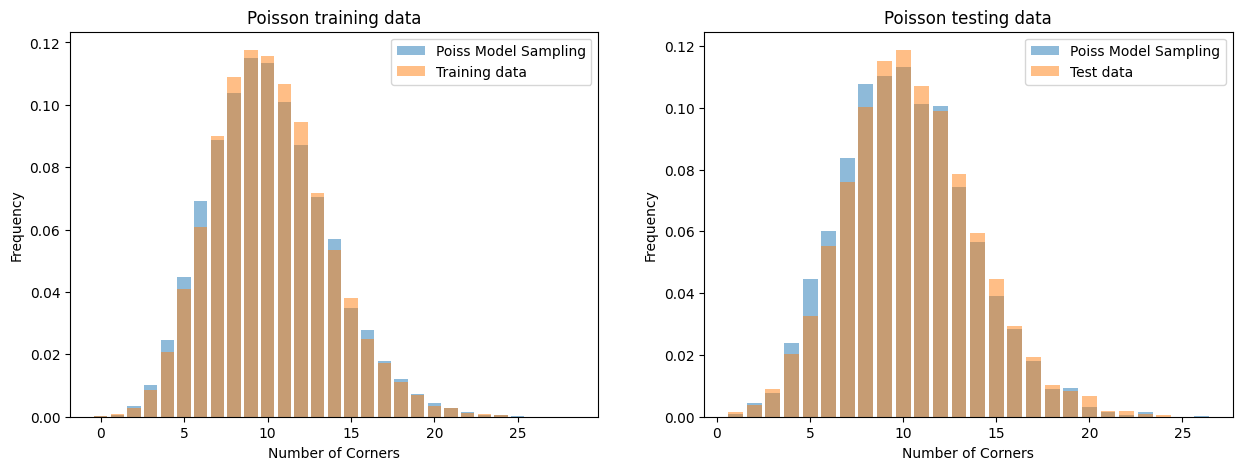

In [59]:
# Evaluation metrics
def match_array_lengths(x1,y1):
    if len(x1)>len(y1):
        y1 = np.pad(y1, (0, len(x1)-len(y1)), constant_values=0)
    elif len(x1)<len(y1):
        x1 = np.pad(x1, (0, len(y1)-len(x1)), constant_values=0)
    return x1, y1

def prediction(data_train, data_test, model):
    # Estimate the expected number of corners for each match using the regressed negative binomial model
    train_pred = model.predict(data_train)
    test_pred = model.predict(data_test)
    # Create sample drawing value from distribution using mean of each match
    sample_corners_train = [nbinom.rvs(n, p=n/(n + mean)) for mean in train_pred]
    sampl_corners_test = [nbinom.rvs(n, p=n/(n + mean)) for mean in test_pred]
    # Calculate probabilities for plots
    train_prob_dist = pd.Series(sample_corners_train).value_counts(normalize=True).sort_index()
    test_prob_dist = pd.Series(sampl_corners_test).value_counts(normalize=True).sort_index()
    return train_prob_dist, test_prob_dist

# Sample target variable from training population
train_ = X_train.copy()
test_ = X_test.copy()

# Select features based on EDA
features_ = [
             #'home_corners_av',#'away_corners_av',
             'league_home_corners_av', 'league_away_corners_av',
             'league_home_goals_av', 'league_away_goals_av',
             ]

# Log transformation due to: positive skew, linearise relation, compression of outliers
for f in features_:
    if f != 'rel_corner_sup' and f != 'rel_goals_sup':
        train_[f] = np.log(train_[f]+1)
        test_[f] = np.log(test_[f]+1)
   
corners_train = train_['Match_Total_Corners'].value_counts(normalize=True).sort_index()
corners_test = test_['Match_Total_Corners'].value_counts(normalize=True).sort_index()

# Fit model to estimate
nbinom_ = NegativeBinomial(train_['Match_Total_Corners'], train_[features_])
nbinom_model = nbinom_.fit()
poiss_model = Poisson(train_['Match_Total_Corners'], train_[features_]).fit()

# Dispersion parameter (common for all matches in this model)
alpha_=nbinom_model.params['alpha']
n = 1/alpha_

print(nbinom_model.summary())
print(poiss_model.summary())

# Range of corners distribution
count_train = np.arange(0,len(corners_train))

# Estimate the expected number of corners for each match using the regressed negative binomial model
probs_pred_train, probs_pred_test = prediction(train_[features_], test_[features_], nbinom_model)
poiss_probs_pred_train, poiss_probs_pred_test = prediction(train_[features_], test_[features_], poiss_model)

# Metric for model
train_tmp , probs_train_tmp = match_array_lengths(corners_train,probs_pred_train)
test_tmp , probs_test_tmp = match_array_lengths(corners_test,probs_pred_test)
nb_r2_train = r2_score(train_tmp,probs_train_tmp)
nb_r2_test = r2_score(test_tmp,probs_test_tmp)

train_tmp , probs_train_tmp = match_array_lengths(corners_train,poiss_probs_pred_train)
test_tmp , probs_test_tmp = match_array_lengths(corners_test,poiss_probs_pred_test)
poiss_r2_train = r2_score(train_tmp,probs_train_tmp)
poiss_r2_test = r2_score(test_tmp,probs_test_tmp)

# Plot
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(probs_pred_train.index, probs_pred_train.values, label='NB Model Sampling' ,alpha = 0.5)
ax[0].bar(corners_train.index, corners_train.values, label='Training data',alpha=0.5)
ax[0].set_xlabel('Number of Corners')
ax[0].set_ylabel('Frequency')
ax[0].set_title(f'NB training data')
ax[0].legend()

ax[1].bar(probs_pred_test.index, probs_pred_test.values, label='NB Model Sampling' ,alpha = 0.5)
ax[1].bar(corners_test.index, corners_test.values, label='Test data',alpha=0.5)
ax[1].set_xlabel('Number of Corners')
ax[1].set_ylabel('Frequency')
ax[1].set_title(f'NB testing data')
ax[1].legend()

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(poiss_probs_pred_train.index, poiss_probs_pred_train.values, label='Poiss Model Sampling' ,alpha = 0.5)
ax[0].bar(corners_train.index, corners_train.values, label='Training data',alpha=0.5)
ax[0].set_xlabel('Number of Corners')
ax[0].set_ylabel('Frequency')
ax[0].set_title(f'Poisson training data')
ax[0].legend()

ax[1].bar(poiss_probs_pred_test.index, poiss_probs_pred_test.values, label='Poiss Model Sampling' ,alpha = 0.5)
ax[1].bar(corners_test.index, corners_test.values, label='Test data',alpha=0.5)
ax[1].set_xlabel('Number of Corners')
ax[1].set_ylabel('Frequency')
ax[1].set_title(f'Poisson testing data')
ax[1].legend()

print(f'NB r2 train: {nb_r2_train}, test: {nb_r2_test}')
print(f'Poiss r2 train: {poiss_r2_train}, test: {poiss_r2_test}')

Independent variables were selected according to the overall goodness-of-fit, their interpretability and an evaluation of the feature p-values and the magnitude of the coefficients relevant to their standard error. The R2 score between the predicted distribution and the historical data in the train and test data are then used to evaluate the model fit. Note that if the test dataset is too small, the score can fluctuate a bit.

The predictors selected were:

- home_corners_av: average number of corners per team at home in a given season
- away_corners_av: average number of corners per team at away in a given season
- league_home_corners_av: average number of corners per team at home in a given league
- league_away_corners_av: average number of corners per team at away in a given league
- league_home_goals_av: average number of goals per team at home in a given league
- league_away_goals_av: average number of goal per team at away in a given league

In the case of the annual averages, the test dataset is assigned the latest seasons values. The aim here is to account for the upturn in corners in more recent seasons. The other variables represent averages for teams, either home or away, across the leagues. This should help the model capture the team and league dependencies.

Interestingly, the pearson correlation plots suggest a team that on average scores more goals in a game, has more corners. However, a teams league average number of goals scored has an inverse relationship with the number of corners won in the regression model. This may be caused by a shared variance between the two and a reallocation of the explanatory power, as a fit without the historical corners averages, this coefficient is positive suggesting it is used as a proxy for corners. While this is not problematic, due to the stability of the coefficient estimates, it does affect the interpretibility of the coefficient estimates.

It's possible this change in sign of the coefficient might also be the 'unexplained' variance in the dependent variable once the historical corners average is accounted for. Once the model no longer has to use the goals as a corners proxy, it may be using it to explain variance in the dependent variable caused by a teams style of play or other match context effects.

The two models result in very similar R2 scores however the additional flexibility of the dispersion parameter in the negative binomial model could help for cases where the overdispersion is larger e.g. if new data were to come in or the final training dataset demonstrates a larger variance, so I will continue with this model.

### Value bet selection
For the final predictions, the full training set is used to fit the model, which is then applied to the test dataset. The probabilities for the over/under/at bets are calculated using the cdf of the negative binomial distribution. In the case where a push bet is possible, the probabilities are updated accordingly to reflect the possibility of this additional outcome. Expected values are calculated using these probabilities with the odds provided, which are subsequently used to see if the bet has value. A bet is selected if the expected value is above a threshold of 5% to reduce risk.

### Value threshold selection & variance
The choice of threshold depends on ones risk tolerence and confidence in the probability estimate. 

Larger variance typically comes from bets with longer odds or lower probability. This is because they will payout infrequently but with larger returns, increasing the range of outcomes. Marginal edges can have high or low variance but the impact of variance on smaller margins is more pronounced as the signal-to-noise ratio gets smaller, meaning short-term outcomes can appear more volatile. Since the profit margin is smaller, it can take a higher volume of bets for the edge to manifest.

Furthermore, smaller value bets are more susceptible to small degrees of mismodelling of the pmf which could make a negative edge look positive. By increasing the threshold, the affect of the inherent variance of the outcome due to random luck is reduced. If we trust the models accuracy, smaller margins could be used if the bet frequency is high as this would smooth out the variance via the law of large numbers.

For the selected bets, the kelly criterion is used to calculate the stake size. Plots of the probabilities and EV for each match clearly display the results.

Optimization terminated successfully.
         Current function value: 2.625911
         Iterations: 17
         Function evaluations: 20
         Gradient evaluations: 20
                      NegativeBinomial Regression Results                      
Dep. Variable:     Match_Total_Corners   No. Observations:                23830
Model:                NegativeBinomial   Df Residuals:                    23826
Method:                            MLE   Df Model:                            3
Date:                 Thu, 28 Nov 2024   Pseudo R-squ.:                0.006762
Time:                         17:55:18   Log-Likelihood:                -62575.
converged:                        True   LL-Null:                       -63002.
Covariance Type:             nonrobust   LLR p-value:                2.203e-184
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
league

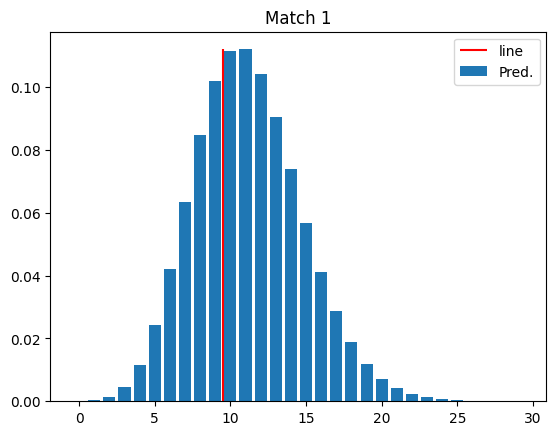

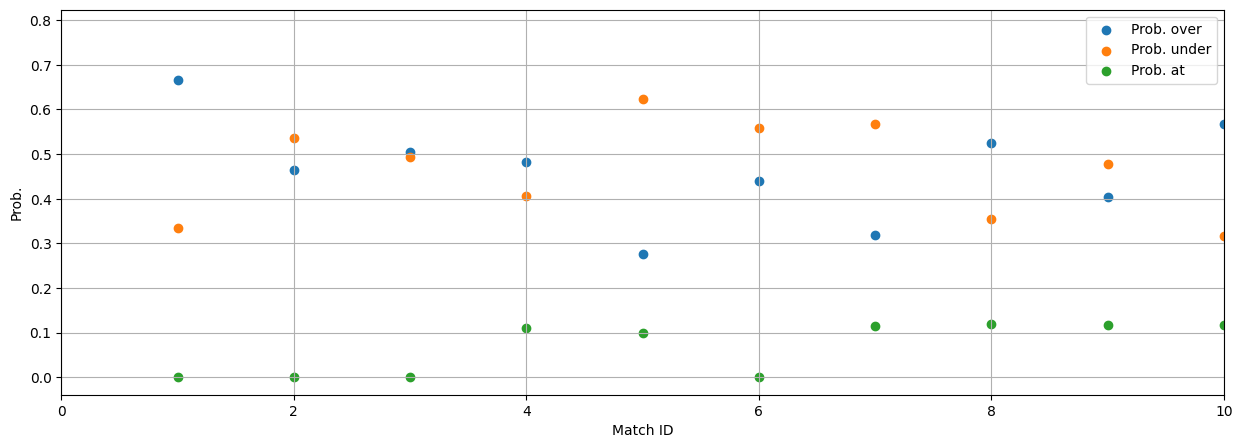

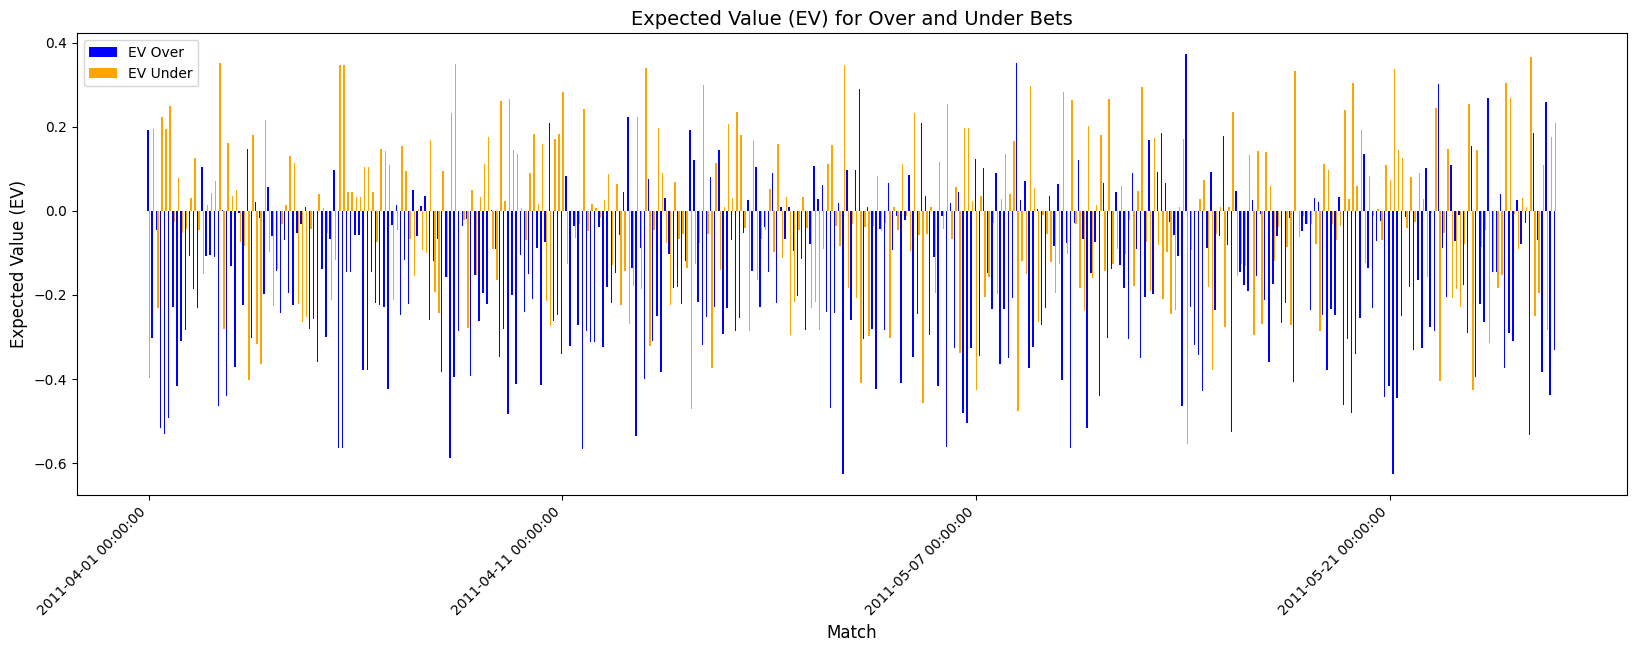

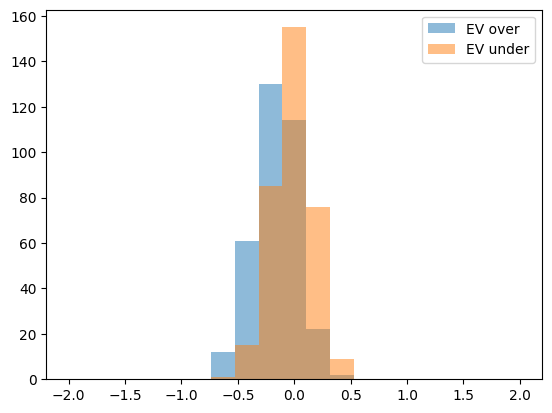

In [35]:
def calc_probs(data_, model, features, k_values = np.arange(0,25)):
    # save match predicted pmfs
    match_pmfs = {}
    # Estimate the expected number of corners for each match using the regressed negative binomial model
    test_pred = model.predict(data_[features])
    # Create distribution for each match
    count = 0
    for index, row in data_.iterrows():
        count+=1
        matchid = row['MatchId']
        mu = test_pred[index]
        alpha_= model.params['alpha']
        r = 1/alpha_
        pmf_vals = nbinom.pmf(k_values, n=r , p= r/(mu+r))
        # Probabilities
        line=row['Line']
        # account for push bets
        if round(line,0) == line:
            prob_under = nbinom.cdf(row['Line']-1, n=r, p=r/(mu+r))
            prob_at = nbinom.pmf(row['Line'], n=r , p= r/(mu+r))
            prob_over = 1 - prob_under - prob_at
        else:
            prob_under = nbinom.cdf(row['Line'], n=r, p=r/(mu+r))
            prob_over = 1 - prob_under
            prob_at = nbinom.pmf(row['Line'], n=r , p= r/(mu+r))# should be zero

        data_.at[index,'P(Over)'] = prob_over
        data_.at[index,'P(Under)'] = prob_under
        data_.at[index,'P(At)'] = prob_at
        
        # Expected value
        EV_over = (prob_over*(row['Over']-1)) - (1-prob_over)
        EV_under = (prob_under*(row['Under']-1)) - (1-prob_under)
        
        data_.at[index,'ev_over'] = EV_over
        data_.at[index,'ev_under'] = EV_under

        # If EV > value threshold bet
        if EV_over>EV_under and EV_over > 0.05:
            data_.at[index,'Bet (U/O)'] = 'O'
            #'Stake'
        elif EV_under>EV_over and EV_under > 0.05:
            data_.at[index,'Bet (U/O)'] = 'U'
        else:
            data_.at[index,'Bet (U/O)'] = '-'

        match_pmfs[matchid] = (pmf_vals, prob_under, prob_at, prob_over, line, EV_over, EV_under)
        
    return match_pmfs

bankroll = 341

xtrain, ytrain = create_training_data(gc_train_df, 2005, 2010)
xtest = create_testing_data(gc_test_df, xtrain, target_present=0)

# Select features based on EDA
features_ = [
             #'home_corners_av','away_corners_av',
             'league_home_corners_av', 'league_away_corners_av',
             'league_home_goals_av', 'league_away_goals_av',
             ]
             
# Log transformation due to: positive skew, linearise relation, compression of outliers
for f in features_:
    if f != 'rel_corner_sup' and f != 'rel_goals_sup':
        xtrain[f] = np.log(xtrain[f]+1)
        xtest[f] = np.log(xtest[f]+1)
    
# Fit model to estimate
nbinom_model = NegativeBinomial(xtrain['Match_Total_Corners'], xtrain[features_]).fit()
print(nbinom_model.summary())

# Simulate the distribution expected number of corners for each match using the regressed negative binomial model
k_values = np.arange(0,30)
matchid_pmf_dict = calc_probs(xtest, nbinom_model, features_, k_values)

count_u = xtest['Bet (U/O)'].value_counts().get('U', 0)
count_o = xtest['Bet (U/O)'].value_counts().get('O', 0)
print(f'# under bets: {count_u}, # over bets: {count_o}')

# Kelly stake criterion

# Kelly stake PnL
B = xtest['Over']-1
P = xtest['P(Over)']
xtest['kelly_over'] = P - ((1-P)/B)

B = xtest['Under']-1
P = xtest['P(Under)']
xtest['kelly_under'] = P - ((1-P)/B)

xtest['Stake'] = xtest.apply(
    lambda row: row['kelly_over'] if row['Bet (U/O)'] == 'O' else (row['kelly_under'] if row['Bet (U/O)']=='U' else 0), 
    axis=1
)
xtest['Stake'] = xtest['Stake']*bankroll
total_kelly_stake = xtest['Stake'].sum()
# Limit sum of bets to bankroll
if total_kelly_stake > bankroll:
    sf = bankroll/total_kelly_stake
    xtest['Stake'] = xtest['Stake']*sf

match_ = 1
fig, ax = plt.subplots()
ax.set_title(f'Match {match_}')
ax.bar(k_values, matchid_pmf_dict[match_][0], label='Pred.')
ax.vlines(matchid_pmf_dict[match_][4], ymin=0, ymax=matchid_pmf_dict[match_][0].max(), label='line', colors='red')
ax.legend()

matchids = matchid_pmf_dict.keys()
punders = [v[1] for v in matchid_pmf_dict.values()]
pats = [v[2] for v in matchid_pmf_dict.values()]
povers = [v[3] for v in matchid_pmf_dict.values()]
ev_over = [v[5] for v in matchid_pmf_dict.values()]
ev_under = [v[6] for v in matchid_pmf_dict.values()]

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(matchids, povers, label='Prob. over')
ax.scatter(matchids, punders, label='Prob. under')
ax.scatter(matchids, pats, label='Prob. at')
ax.set_xlim(0,10)
ax.set_xlabel('Match ID')
ax.set_ylabel('Prob.')
ax.legend()
ax.grid()

# Bars for EV Over and Under
bar_width = 0.35
x = np.arange(len(matchids))
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(x - bar_width/2, ev_over, width=bar_width, label='EV Over', color='blue')
ax.bar(x + bar_width/2, ev_under, width=bar_width, label='EV Under', color='orange')
ax.set_xlabel('Match', fontsize=12)
ax.set_ylabel('Expected Value (EV)', fontsize=12)
ax.set_title('Expected Value (EV) for Over and Under Bets', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(xtest['Date'], rotation=45, ha='right', fontsize=10)
ax.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=4))

fig, ax = plt.subplots()
bins = np.linspace(-2,2,20)
ax.hist(ev_over, label='EV over', bins=bins,alpha=0.5)
ax.hist(ev_under, label='EV under', bins=bins, alpha=0.5)
ax.legend()

A total of 185 bets are selected, 94 under bets and 91 over bets with stake sizes up to around 6 units according to the kelly stake strategy applied. The stake size and bet type are appended to the test dataset along with the probability.

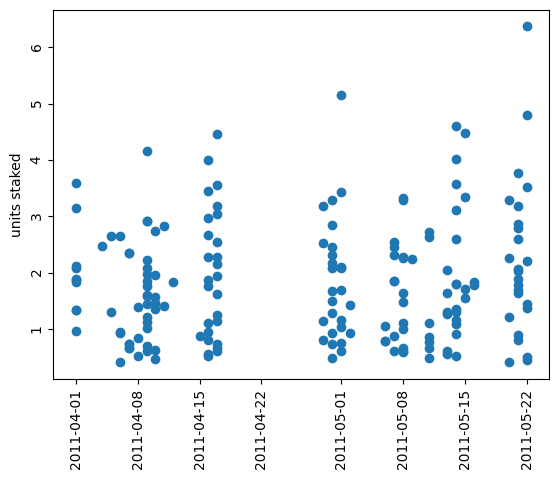

In [17]:
fig, ax = plt.subplots()
dates = xtest[ xtest['Stake']!=0 ]['Date']
bets = xtest[ xtest['Stake']!=0 ]['Stake']
ax.set_ylabel('units staked')
ax.scatter(dates , bets)
ax.tick_params(rotation=90)

In [18]:
len(xtest)

341

In [19]:
xtest.drop([ 'year', 'Home_corners_3form',
       'Away_corners_3form', 'Home_corners_10form', 'Away_corners_10form',
       'Home_goals_3form', 'Away_goals_3form', 'Home_goals_10form',
       'Away_goals_10form', 'home_goals_av', 'home_corners_av',
       'away_goals_av', 'away_corners_av', 'overall_league_home_goals_av',
       'overall_league_home_corners_av', 'overall_league_away_goals_av',
       'overall_league_away_corners_av', 'Mean_Corners_Per_League',
       'league_home_goals_av', 'league_home_corners_av',
       'league_away_goals_av', 'league_away_corners_av', 'total_corners_exp',
       'rel_corner_sup', 'total_goals_exp', 'rel_goals_sup', 'ev_over',
       'ev_under', 'kelly_over', 'kelly_under'],axis=1,inplace=True)

In [20]:
xtest.to_csv('test_updated.csv', index=False)